# Описание задания
1. Проанализировать данные в файле
2. Построить гипотезы
3. Обучить логистическую регрессию
4. Снять метрики качества
5. Результат выполненного тестового задания: ссылка на открытый репозиторий в Git

В файле поле Marker - целевая функция

In [53]:
# !pip install pyxlsb

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

DATA_PATH = '/content/drive/MyDrive/alpha_test_task/Training.xlsb'
RANDOM_STATE = 42

Вспомогательные функции:

In [3]:
def inspect_table(data):
    types = data.dtypes
    total = data.count()
    nan_report = data.isna().sum(0)
    unique_report = data.nunique()

    report = pd.concat({
                'type': types,
                'total': total,
                'nan': nan_report,
                'n_unique': unique_report}, axis=1)  
    
    return report


def compute_outliers_borders(data, col_name):
    IQR = data[col_name].quantile(0.75) - data[col_name].quantile(0.25)
    lower_limit = data[col_name].quantile(0.25) - 1.5 * IQR
    upper_limit = data[col_name].quantile(0.75) + 1.5 * IQR
    return IQR, lower_limit, upper_limit


def print_numeric_stats(data, col_name):
    print(f'Count: {data[col_name].count()}')
    print(f'Distinct: {data[col_name].nunique()}')
    print(f'Distinct(%): {data[col_name].nunique() / data[col_name].count() * 100}%')
    print(f'Minimum: {data[col_name].min()}')
    print(f'Maximum: {data[col_name].max()}')
    print(f'Mean: {data[col_name].mean()}')
    print(f'Median: {data[col_name].median()}')
    IQR, lower_limit, upper_limit = compute_outliers_borders(data, col_name)
    print(f'IQR: {IQR}')
    
    print()
    print(f'Нижняя граница выброса: {lower_limit if lower_limit >= data[col_name].min() else data[col_name].min()}')
    print(f'Верхняя граница выброса: {upper_limit if upper_limit <= data[col_name].max() else data[col_name].max()}')
    print(f'Кол-во выбросов: {data[(data[col_name] < lower_limit) | (data[col_name] > upper_limit)].shape[0]}')
    print(f'Кол-во выбросов(%): {((data[(data[col_name] < lower_limit) | (data[col_name] > upper_limit)].shape[0]) / data[col_name].count()) * 100}')
    print()

    print('После логарифмирования:')
    df = data.copy()
    df[col_name] = np.log(df[col_name] + 1)
    IQR, lower_limit, upper_limit = compute_outliers_borders(df, col_name)
    print(f'Нижняя граница выброса: {lower_limit if lower_limit >= df[col_name].min() else df[col_name].min()}')
    print(f'Верхняя граница выброса: {upper_limit if upper_limit <= df[col_name].max() else df[col_name].max()}')
    print(f'Кол-во выбросов: {df[(df[col_name] < lower_limit) | (df[col_name] > upper_limit)].shape[0]}')
    print(f'Кол-во выбросов(%): {((df[(df[col_name] < lower_limit) | (df[col_name] > upper_limit)].shape[0]) / df[col_name].count()) * 100}')


def print_categorical_stats(data, col_name):
    print(f'Column: {col_name}')
    display(pd.DataFrame({
      'count': data[col_name].value_counts(),
      'frequency(%)': (data[col_name].value_counts() / data.shape[0]) * 100
    }))
    return


def plot_univariate_numeric(data, col_name, figsize=(20, 10)):
    df = data.copy()
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=figsize)
    sns.histplot(x=col_name, data=df, ax=axes[0], kde=True)
    sns.boxplot(y=col_name, data=df, ax=axes[1])

    # log column
    df[f'{col_name}_log'] = np.log(df[col_name] + 1)
    sns.histplot(x=f'{col_name}_log', data=df, ax=axes[2], kde=True)
    sns.boxplot(y=f'{col_name}_log', data=df, ax=axes[3])


def plot_univariate_categorical(data, col_name, figsize=(20, 10)):
    total = data[col_name].count()
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=col_name, hue=col_name, data=data)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(percentage,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=14)
    plt.show()


def plot_bivariate_numeric(data, col_name, figsize=(20, 10)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    sns.kdeplot(data=data, x=col_name, hue='MARKER', common_norm=False, ax=axes[0])
    sns.boxplot(data=data, x='MARKER', y=col_name, ax=axes[1])


def plot_bivariate_categorical(data, col_name, figsize=(20, 10)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    total = data[col_name].count()
    sns.countplot(data=data, x=col_name, hue='MARKER', ax=axes[0])
    for p in axes[0].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        axes[0].annotate(percentage,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=14)

    sns.barplot(data=data, x=col_name, y='MARKER', ax=axes[1], ci=None)

    axes[0].tick_params('x', labelrotation=45)
    axes[1].tick_params('x', labelrotation=45)


def plot_num_cat_boxplot(data, num_col_name, cat_col_name, figsize=(20,10)):
    fig = plt.figure(figsize=(15, 7))
    sns.boxplot(x=cat_col_name, y=num_col_name, hue='MARKER', data=data)
    plt.show()


def plot_multiple_barplot(data, x, hue, figsize=(20,10)):
    fig = plt.figure(figsize=(figsize))
    sns.barplot(data=data, x=x, y="MARKER", hue=hue, ci=None)
    plt.show()

# Оценка качества данных
В этом разделе мы познакомимся с данными и сделаем предварительную оценку их качества.

In [4]:
data = pd.read_excel(DATA_PATH)
data.head()

,ID,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,MARKER
0,1,0.198778,0.099389,0.00,799.90,1.777556,0.888778,13,3.49,Woman,33.750000,Mogilev region,132,NE employee,Secondary education (plus special education),Married,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
1,2,0.043000,0.021264,49.97,173.03,0.384511,0.190143,13,3.49,Woman,33.250000,Minsk region,6,NE employee,Secondary education (plus special education),Married,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
2,3,0.067073,0.067073,0.00,329.90,0.599818,0.599818,13,3.49,Woman,38.583333,Vitebsk region,71,NE employee,Secondary education (plus special education),Divorced/widow,1 One,property,No,No couple,No,Yes,No,Yes,No,0
3,4,0.052700,0.052700,0.00,235.65,0.471300,0.471300,13,3.49,Woman,61.250000,Minsk region,48,Pensioner,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
4,5,0.141880,0.141880,0.00,634.45,1.268900,1.268900,13,3.49,Woman,48.583333,Brest region,48,NE employee,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,No,No,No,No,0


In [5]:
print(f'Количество строк: {data.shape[0]}') 
print(f'Количество столбцов: {data.shape[1]}')

Количество строк: 89734
Количество столбцов: 26


Сразу видим, что у нас есть признак **ID**. Проверим его на наличие дубликатов, и если дубликатов нет, то мы можем удалить этот столбец/установить в качестве индекса датафрейма и исключить из последующего анализа:

In [6]:
data['ID'].duplicated().sum()

0

Все записи в этом столбце уникальные, можем установить его как индекс:

In [7]:
data.set_index('ID', inplace=True)

### Общая статистика

In [8]:
report = inspect_table(data)
report

,type,total,nan,n_unique
A,float64,89734,0,46408
B,float64,89734,0,56381
C,float64,89734,0,11051
D,float64,89734,0,14941
E,float64,89734,0,49962
F,float64,89734,0,59471
G,int64,89734,0,11
H,float64,89734,0,13
I,object,89734,0,2
J,float64,89734,0,528


Проверка наличия дубликатов:

In [9]:
data.duplicated().sum()

0

Предварительные результаты:
- нет пропущенных значений
- нет дублирующихся строк
- признаки **G**, **H** и **MARKER** (таргет) заданы как числовые, но принимают малое количество значений. Посмотрим на их значения и частоты и попробуем решить, можем ли мы считать их категориальными:

In [10]:
for col_name in ['G', 'H', 'MARKER']:
    print_categorical_stats(data, col_name)

Column: G


,count,frequency(%)
5,24914,27.764281
13,22011,24.529164
3,14842,16.539996
10,12424,13.845365
2,5287,5.891858
20,3722,4.147815
4,3557,3.963938
6,1518,1.691666
11,804,0.895981
9,506,0.563889


Column: H


,count,frequency(%)
0.000,63346,70.593086
1.990,14108,15.722023
2.490,5784,6.445717
0.010,5115,5.700181
3.500,298,0.332093
2.500,277,0.308690
2.990,255,0.284173
1.235,231,0.257428
1.100,117,0.130385
1.170,109,0.121470


Column: MARKER


,count,frequency(%)
0,89392,99.618874
1,342,0.381126


- **MARKER** (таргет) является категориальным признаком и имеет большой дисбаланс, мы должны учитывать это при выборе метрик и их оценке
- я не уверена, как интерпретировать значение признака **G**, оставим его пока как есть, но будем иметь в виду при дальнейшем анализе 
- тоже самое можно сказать и про признак **H**. Он принимает вещественные значения, но 70% из них равны 0.0, может ли это указывать на отсутствующее значение или какую-то категорию? Также только одна запись в наборе данных принимает значение 3.0 (выброс?)

In [11]:
data[['MARKER']] = data[['MARKER']].astype(object)

### Числовые переменные

In [12]:
num_cols = data.select_dtypes(include='number').columns.tolist()
print(num_cols)
print(f"Количество числовых переменных: {len(num_cols)}")

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'L']
Количество числовых переменных: 10


In [13]:
data.describe()

,A,B,C,D,E,F,G,H,J,L
count,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000
mean,0.167863,0.113511,85.801266,548.507954,1.011455,0.683640,7.854358,0.510274,41.140778,103.719092
std,0.153851,0.105340,105.366771,448.686233,0.910583,0.622047,4.754588,0.928146,11.129976,100.458022
min,0.000002,0.000001,0.000000,49.980000,0.000016,0.000012,2.000000,0.000000,21.000000,0.000000
25%,0.065843,0.042922,20.570000,227.030000,0.405983,0.263775,4.000000,0.000000,32.083333,29.000000
50%,0.119133,0.079733,50.020000,408.735000,0.749403,0.499387,5.000000,0.000000,40.000000,69.000000
75%,0.220000,0.146990,108.930000,746.710000,1.333367,0.899260,13.000000,0.010000,50.000000,144.000000
max,7.067250,0.874025,2682.420000,4999.000000,35.337000,10.352991,24.000000,3.500000,64.916667,540.000000


- для большинства признаков среднее и медианное значение значительно отличается от максимального, следует проверить эти признаки на наличие выбросов
- признак **J** выглядит как возраст (если предположить, что решается задача кредитного скоринга/предсказания дефолта клиента, то можно воспользоваться информацией с сайта Альфа-Банка, где указано, что на момент обращения возраст получателей кредита – от 21 года, а к моменту полного погашения – не более 64 лет, что согласуется с минимальным и максимальным значением данной колонки)

### Категориальные переменные

In [14]:
cat_cols = data.select_dtypes(include='object').columns.tolist()
print(cat_cols)
print(f"Количество категориальных переменных: {len(cat_cols)}")

['I', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'MARKER']
Количество категориальных переменных: 15


In [15]:
data.describe(include=object)

,I,K,M,N,O,P,Q,R,S,T,U,V,W,X,MARKER
count,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734
unique,2,7,5,4,4,5,3,2,5,2,2,3,2,2,2
top,Woman,Minsk region,NE employee,Secondary education (plus special education),Married,0 Zero,property,No,Works,Yes,Yes,No,No,No,0
freq,48996,15274,72475,58363,63273,44229,81457,74357,47413,75356,76546,78462,51577,55095,89392


- мы уже отметили ранее сильный дисбаланс в таргете
- к тому же мы видим достаточно сильный дисбаланс в признаках **M**, **Q**, **R**, **T**, **U**, **V**
- в значениях признака **P** присутствует дублирующаяся информация (0 Zero)
- мы подробнее рассмотрим уникальные значения признаков и их частоты в следующей части

### Ключевые пункты

- пропущенных значений не обнаружено
- дублирующихся строк не обнаружено
- **MARKER** (таргет) - бинарный признак и имеет огромный дисбаланс (99,6% объектов класса 0). Можно предположить, что мы имеем дело с задачей кредитного скоринга/предсказания дефолта клиента (это также может быть прогнозирование оттока клиентов или любая другая задача, но я склоняюсь к задаче кредитного скоринга из-за диапазона значений признака **J**, который, по-видимому, является возрастом)

# Исследование данных

## 1. Исследование каждого отдельного признака

### 1.1 Числовые переменные

In [16]:
num_cols

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'L']

**A:**

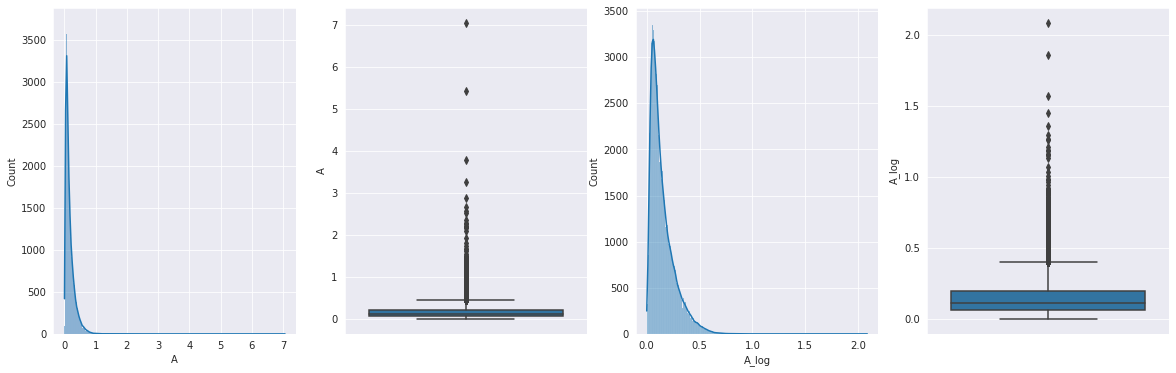

In [17]:
plot_univariate_numeric(data, 'A', figsize=(20, 6))

In [18]:
print_numeric_stats(data, 'A')

Count: 89734
Distinct: 46408
Distinct(%): 51.71729779124969%
Minimum: 1.6280000000000001e-06
Maximum: 7.06725
Mean: 0.16786345693268295
Median: 0.11913333333333334
IQR: 0.15415714285714285

Нижняя граница выброса: 1.6280000000000001e-06
Верхняя граница выброса: 0.4512357142857143
Кол-во выбросов: 5046
Кол-во выбросов(%): 5.623286602625538

После логарифмирования:
Нижняя граница выброса: 1.627998674729687e-06
Верхняя граница выброса: 0.40147829489017595
Кол-во выбросов: 3804
Кол-во выбросов(%): 4.239195845498919


- распределение скошено вправо, после взятия логарифма оно всё еще скошено вправо, так что оставим как есть
- выбросов довольно много, но я считаю границы выбросов для скошенного распределения как для нормального (Q1/Q3 ± 1.5 * IQR), хотя скорее всего в данном случае их нужно обнаруживать каким-то другим способом. Так что удалять эти выбросы не будем

**B:**

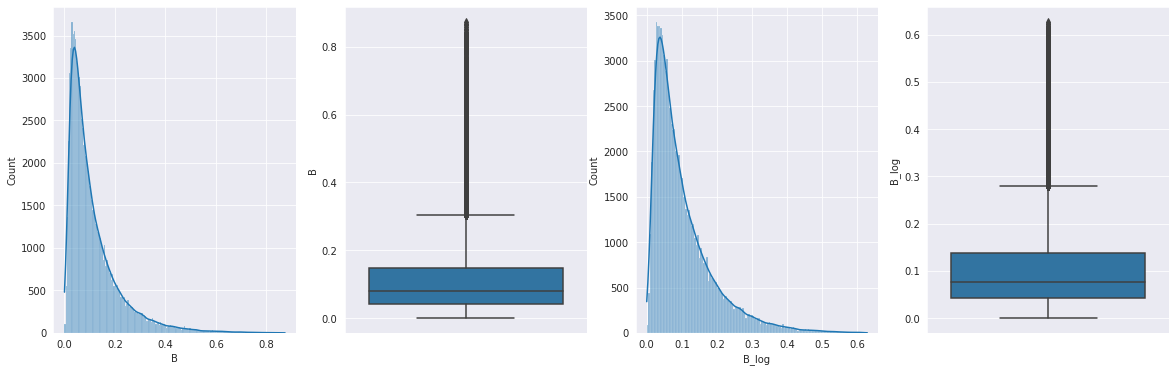

In [19]:
plot_univariate_numeric(data, 'B', figsize=(20, 6))

In [20]:
print_numeric_stats(data, 'B')

Count: 89734
Distinct: 56381
Distinct(%): 62.831256825729376%
Minimum: 1.2059259259259261e-06
Maximum: 0.874025
Mean: 0.11351094285393405
Median: 0.07973333333333334
IQR: 0.10406784945086293

Нижняя граница выброса: 1.2059259259259261e-06
Верхняя граница выброса: 0.303091642597347
Кол-во выбросов: 5485
Кол-во выбросов(%): 6.112510308244367

После логарифмирования:
Нижняя граница выброса: 1.205925198878572e-06
Верхняя граница выброса: 0.27981290178840934
Кол-во выбросов: 4572
Кол-во выбросов(%): 5.09505872913277


- распределение скошено вправо, после взятия логарифма оно всё еще скошено вправо, так что оставим как есть
- выбросов довольно много, но я считаю границы выбросов для скошенного распределения как для нормального (Q1/Q3 ± 1.5 * IQR), хотя скорее всего в данном случае их нужно обнаруживать каким-то другим способом. Так что удалять эти выбросы не будем

**C:**

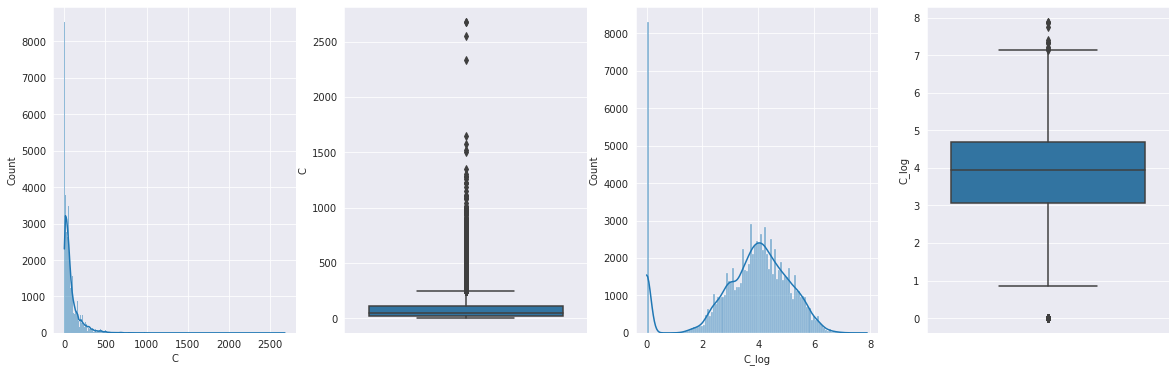

In [21]:
plot_univariate_numeric(data, 'C', figsize=(20, 6))

In [22]:
print_numeric_stats(data, 'C')

Count: 89734
Distinct: 11051
Distinct(%): 12.315287404996992%
Minimum: 0.0
Maximum: 2682.42
Mean: 85.80126585240824
Median: 50.02
IQR: 88.36000000000001

Нижняя граница выброса: 0.0
Верхняя граница выброса: 241.47000000000003
Кол-во выбросов: 6950
Кол-во выбросов(%): 7.745113334967793

После логарифмирования:
Нижняя граница выброса: 0.6284929516165039
Верхняя граница выброса: 7.142654308375334
Кол-во выбросов: 8305
Кол-во выбросов(%): 9.255131834087415


In [23]:
data['C'] = np.log(data['C'] + 1)

- после взятия логарифма распределение приняло очень интересную форму: достаточно большая часть объектов сконцентрировалась около нуля, а все остальные приняли форму нормального распределения. Можно попробовать добавить новый бинарный признак (в одну группу попадут объекты, у которых C = 0, а в другую - все остальные) и посмотреть, есть ли какая-то зависимость с таргетом; также 0 может быть индикатором пропущенного значения и можно попробовать заполнить нули средним значением

In [24]:
data['C_is_0'] = (data['C'] == 0).astype(int).astype(object)

**D:**

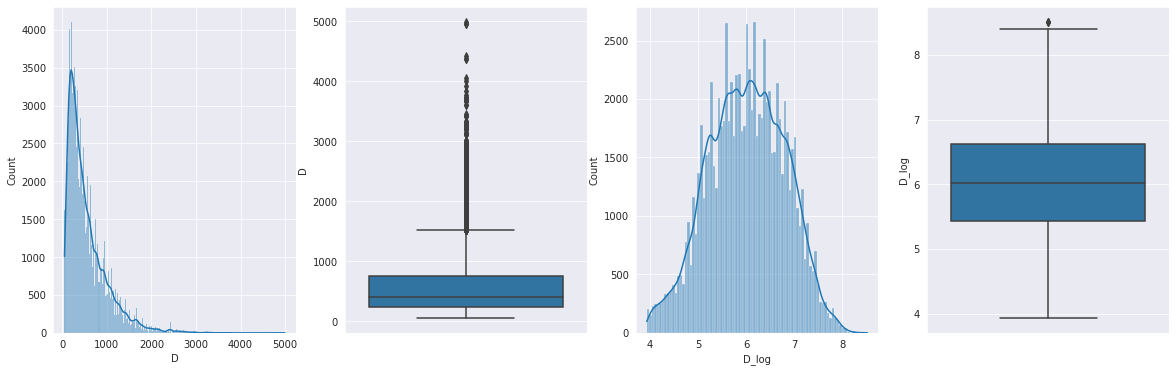

In [25]:
plot_univariate_numeric(data, 'D', figsize=(20, 6))

In [26]:
print_numeric_stats(data, 'D')

Count: 89734
Distinct: 14941
Distinct(%): 16.65032206298616%
Minimum: 49.98
Maximum: 4999.0
Mean: 548.5079541756749
Median: 408.735
IQR: 519.6800000000001

Нижняя граница выброса: 49.98
Верхняя граница выброса: 1526.23
Кол-во выбросов: 3558
Кол-во выбросов(%): 3.9650522655849514

После логарифмирования:
Нижняя граница выброса: 3.9314333989479695
Верхняя граница выброса: 8.398322206791999
Кол-во выбросов: 3
Кол-во выбросов(%): 0.003343214389194731


In [27]:
data['D'] = np.log(data['D'] + 1)

IQR, lower_limit, upper_limit = compute_outliers_borders(data, 'D')
outliers = data[(data['D'] < lower_limit) | (data['D'] > upper_limit)]
outliers['MARKER'].value_counts()

0    3
Name: MARKER, dtype: int64

- распределение скошено вправо - взяли логарифм
- выбросов всего 3 и все принадлежат классу 0, можно удалить

In [28]:
data.drop(index=outliers.index.tolist(), inplace=True)

**E:**

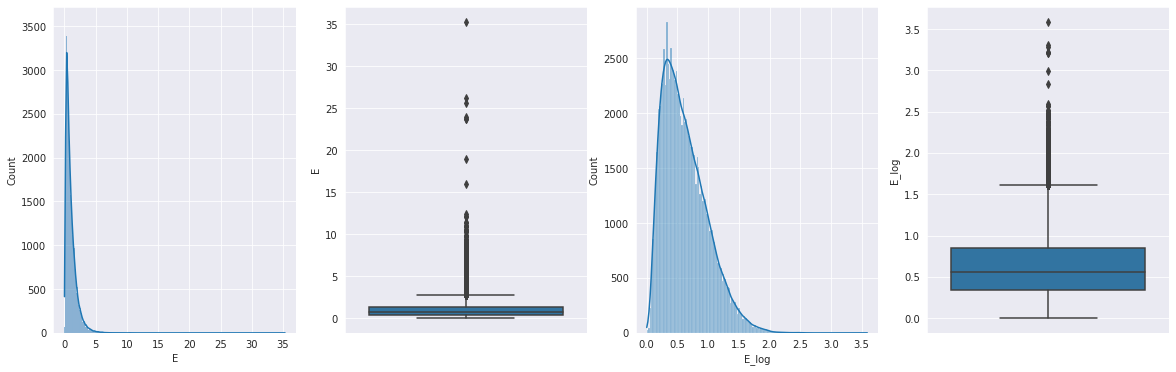

In [29]:
plot_univariate_numeric(data, 'E', figsize=(20, 6))

In [30]:
print_numeric_stats(data, 'E')

Count: 89731
Distinct: 49959
Distinct(%): 55.67641060503059%
Minimum: 1.599e-05
Maximum: 35.337
Mean: 1.0112886229147546
Median: 0.7493833333333333
IQR: 0.927372222222222

Нижняя граница выброса: 1.599e-05
Верхняя граница выброса: 2.724408333333333
Кол-во выбросов: 4341
Кол-во выбросов(%): 4.837792958955099

После логарифмирования:
Нижняя граница выброса: 1.5989872161389532e-05
Верхняя граница выброса: 1.6071630260064083
Кол-во выбросов: 1181
Кол-во выбросов(%): 1.3161560664653242


- распределение скошено вправо, после взятия логарифма оно всё еще скошено вправо, так что оставим как есть
- выбросов довольно много, но я считаю границы выбросов для скошенного распределения как для нормального (Q1/Q3 ± 1.5 * IQR), хотя скорее всего в данном случае их нужно обнаруживать каким-то другим способом. Так что удалять эти выбросы не будем

**F:**

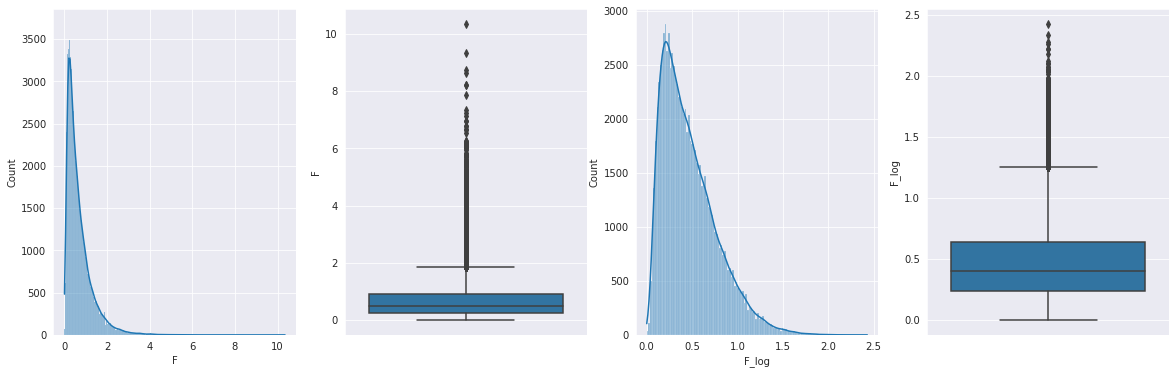

In [31]:
plot_univariate_numeric(data, 'F', figsize=(20, 6))

In [32]:
print_numeric_stats(data, 'F')

Count: 89731
Distinct: 59468
Distinct(%): 66.2736401020829%
Minimum: 1.1844444444444445e-05
Maximum: 10.352991452991452
Mean: 0.683580536976036
Median: 0.499375
IQR: 0.6354014285714286

Нижняя граница выброса: 1.1844444444444445e-05
Верхняя граница выброса: 1.8522785714285714
Кол-во выбросов: 4622
Кол-во выбросов(%): 5.150951176293589

После логарифмирования:
Нижняя граница выброса: 1.1844374299475072e-05
Верхняя граница выброса: 1.252395921142297
Кол-во выбросов: 1784
Кол-во выбросов(%): 1.9881646253803034


- распределение скошено вправо, после взятия логарифма оно всё еще скошено вправо, так что оставим как есть
- выбросов довольно много, но я считаю границы выбросов для скошенного распределения как для нормального (Q1/Q3 ± 1.5 * IQR), хотя скорее всего в данном случае их нужно обнаруживать каким-то другим способом. Так что удалять эти выбросы не будем

**G:**

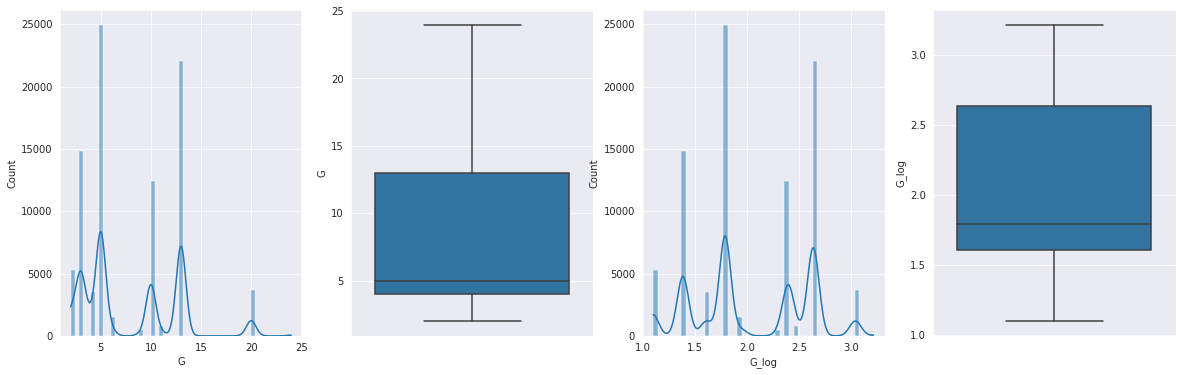

In [33]:
plot_univariate_numeric(data, 'G', figsize=(20, 6))

- будем рассматривать этот признак как категориальный

In [34]:
data[['G']] = data[['G']].astype(object)

**H:**

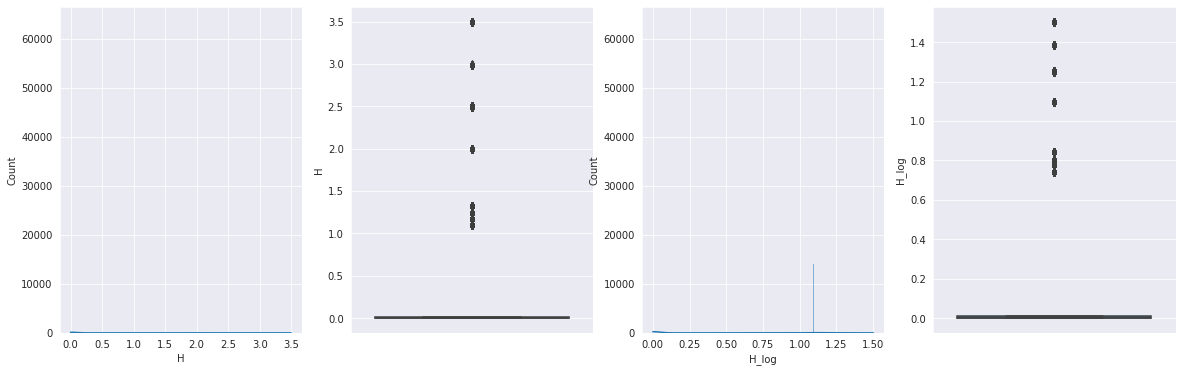

In [35]:
plot_univariate_numeric(data, 'H', figsize=(20, 6))

- будем рассматривать этот признак как категориальный
- можно попробовать вывести новый бинарный признак (значение признака = 0 или нет); либо 0 может быть индикатором пропущенного значения

In [36]:
data[['H']] = data[['H']].astype(object)
data['H_is_0'] = (data['H'] == 0).astype(int).astype(object)

**J**:

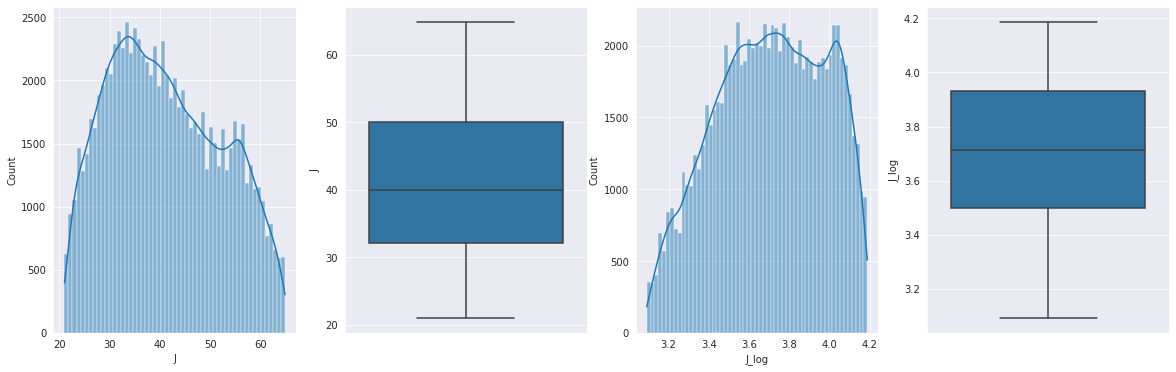

In [37]:
plot_univariate_numeric(data, 'J', figsize=(20, 6))

In [38]:
print_numeric_stats(data, 'J')

Count: 89731
Distinct: 528
Distinct(%): 0.5884254048210763%
Minimum: 21.0
Maximum: 64.91666666666667
Mean: 41.140751245389
Median: 40.0
IQR: 17.916666666666664

Нижняя граница выброса: 21.0
Верхняя граница выброса: 64.91666666666667
Кол-во выбросов: 0
Кол-во выбросов(%): 0.0

После логарифмирования:
Нижняя граница выброса: 3.091042453358316
Верхняя граница выброса: 4.1883913179796535
Кол-во выбросов: 0
Кол-во выбросов(%): 0.0


- признак - возраст, среднее значение - 41 год
- распределение слегка скошено вправо, нормальное, логарифм брать не будем
- выбросов нет

**L:**

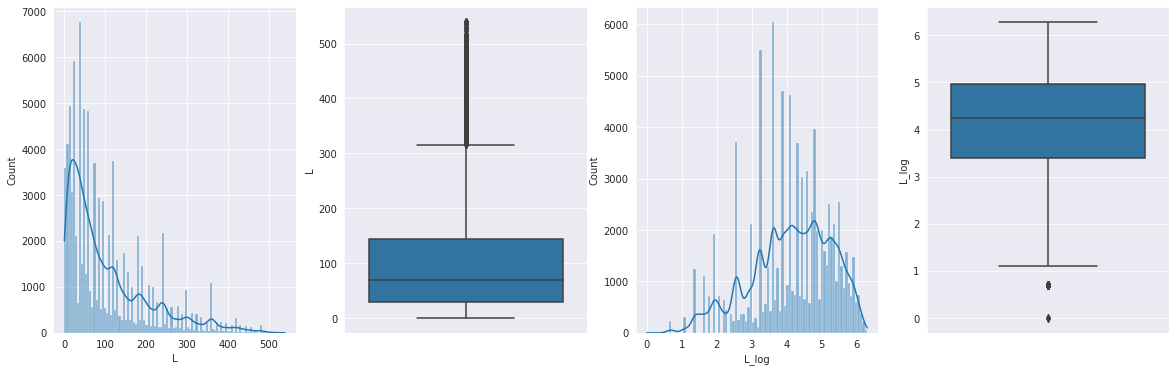

In [39]:
plot_univariate_numeric(data, 'L', figsize=(20, 6))

In [40]:
print_numeric_stats(data, 'L')

Count: 89731
Distinct: 511
Distinct(%): 0.569479889893125%
Minimum: 0
Maximum: 540
Mean: 103.72209158484804
Median: 69.0
IQR: 115.0

Нижняя граница выброса: 0
Верхняя граница выброса: 316.5
Кол-во выбросов: 4665
Кол-во выбросов(%): 5.19887218464076

После логарифмирования:
Нижняя граница выброса: 1.0378928405245271
Верхняя граница выброса: 6.293419278846481
Кол-во выбросов: 226
Кол-во выбросов(%): 0.251863904336294


In [41]:
data['L'] = np.log(data['L'] + 1)

IQR, lower_limit, upper_limit = compute_outliers_borders(data, 'L')
outliers = data[(data['L'] < lower_limit) | (data['L'] > upper_limit)]
outliers['MARKER'].value_counts()

0    226
Name: MARKER, dtype: int64

- распределение скошено вправо - взяли логарифм
- выбросов немного, все принадлежат классу 0, можно удалить

In [42]:
data.drop(index=outliers.index.tolist(), inplace=True)

### 1.2 Категориальные переменные

In [43]:
cat_cols = data.select_dtypes(include='object').columns.tolist()
print(cat_cols)
print(f'Количество категориальных переменных: {len(cat_cols)}')

['G', 'H', 'I', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'MARKER', 'C_is_0', 'H_is_0']
Количество категориальных переменных: 19


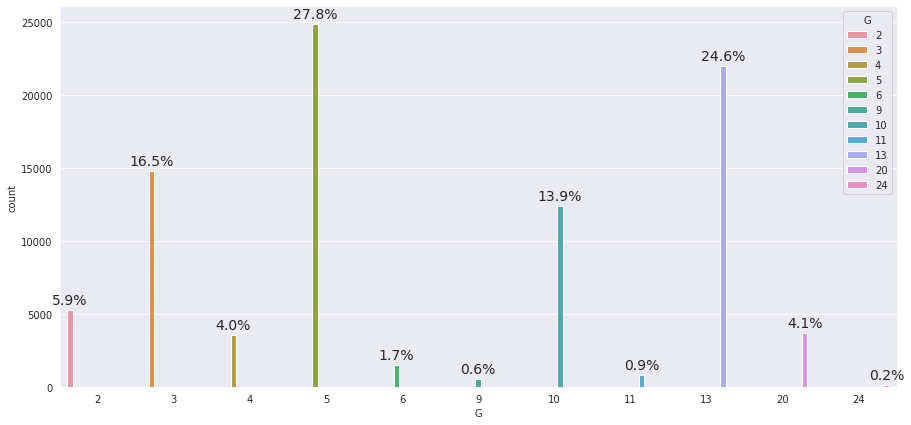

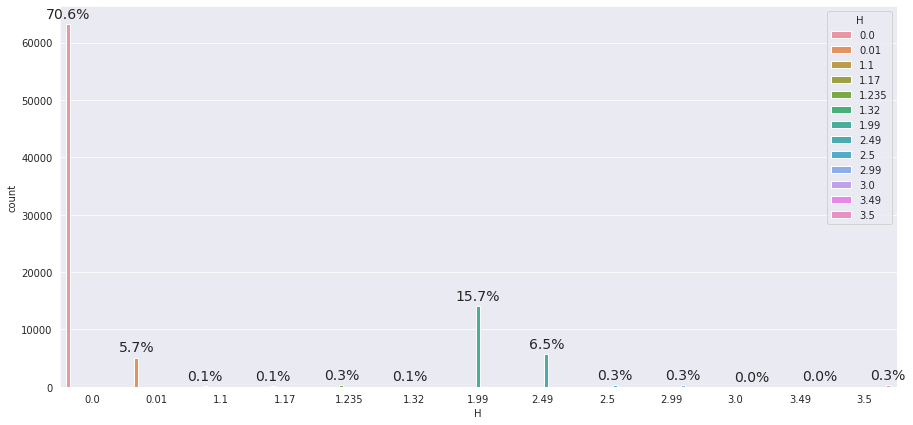

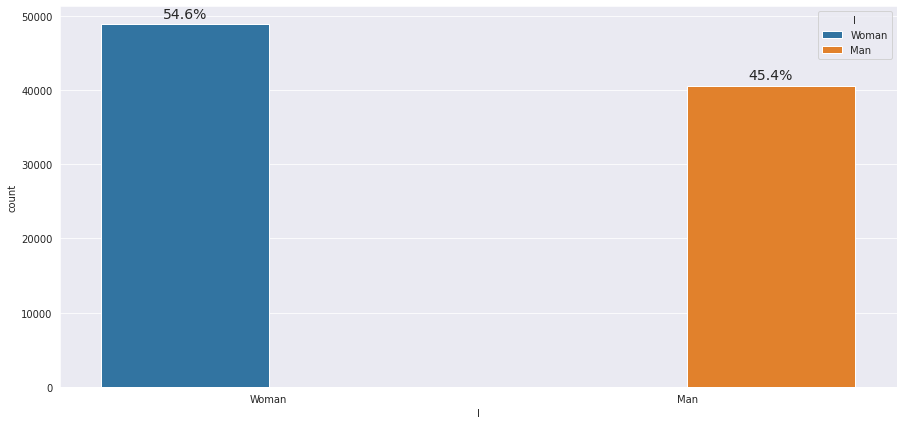

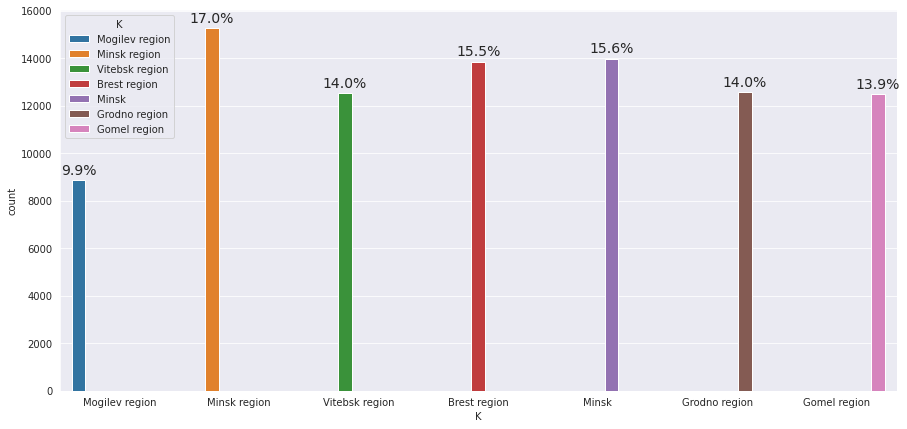

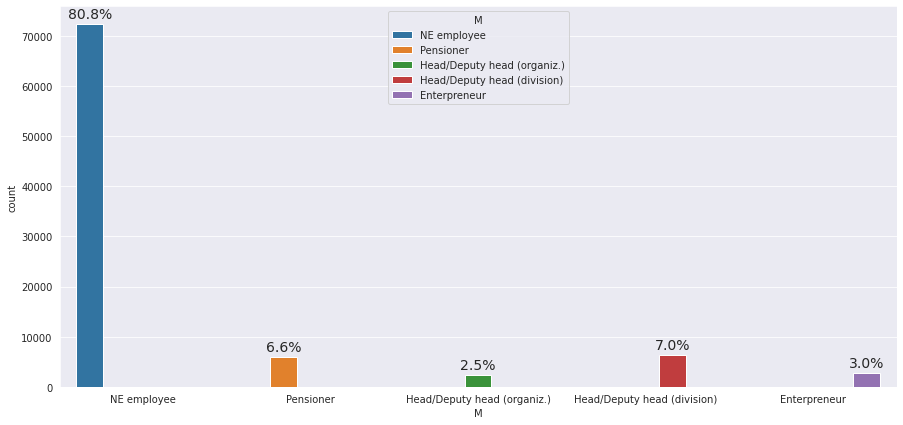

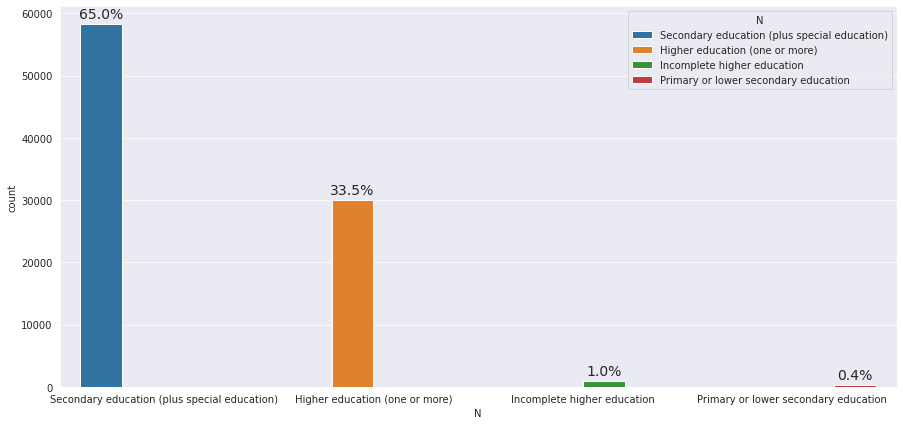

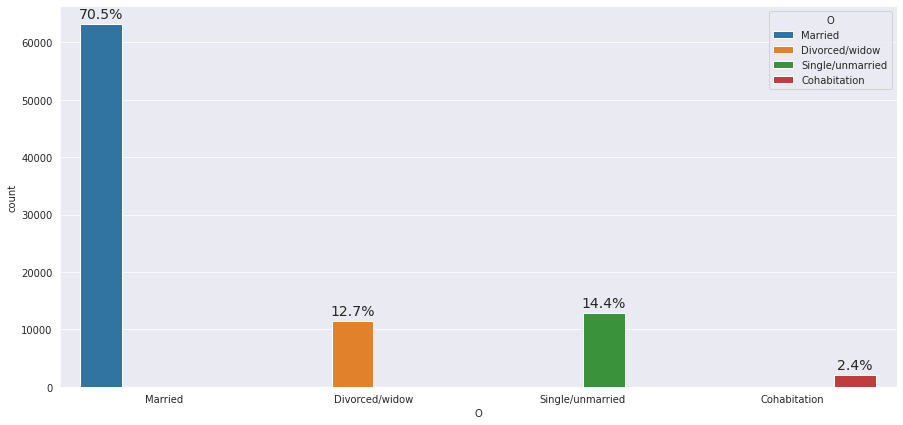

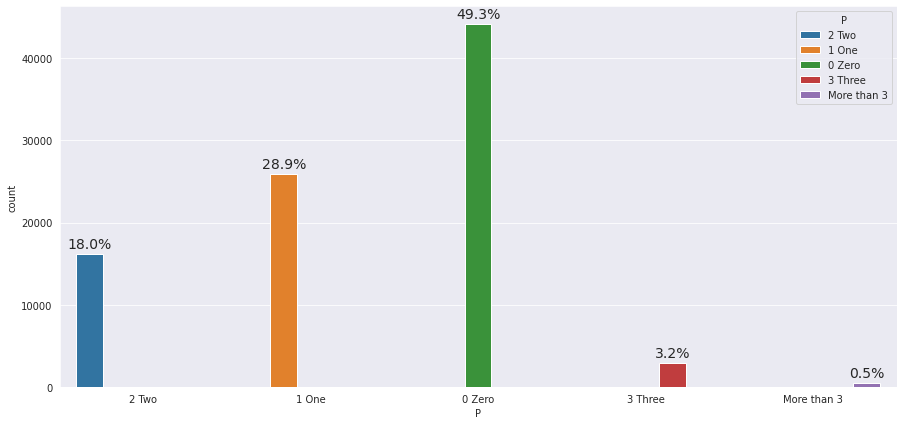

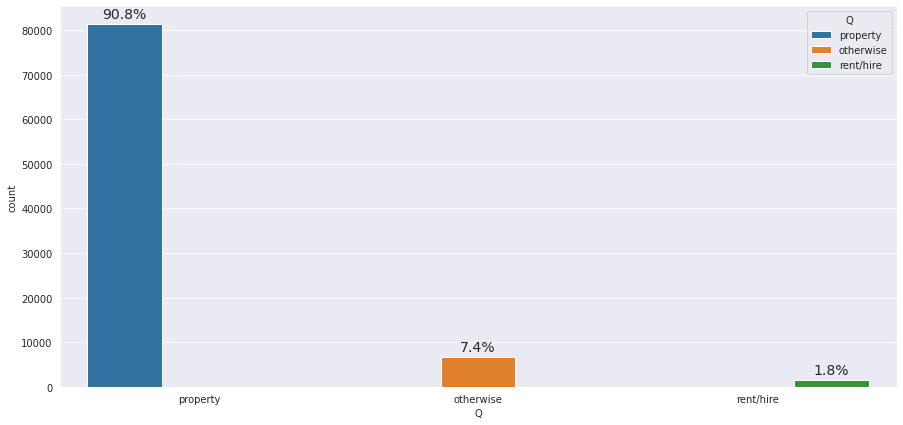

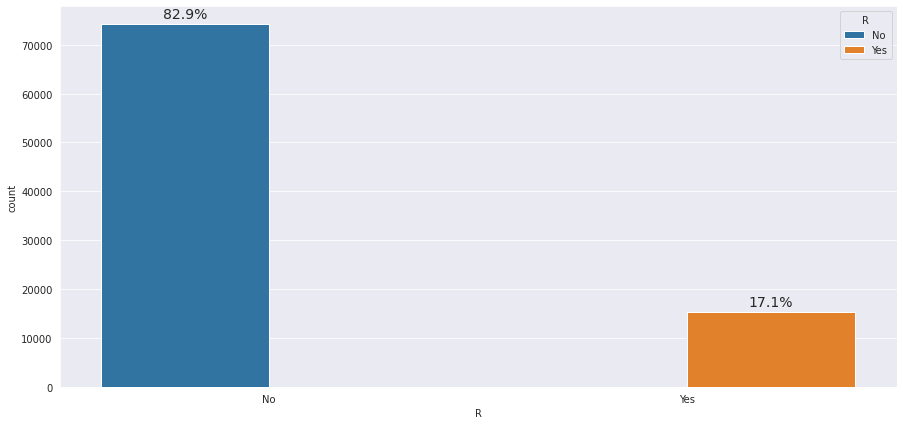

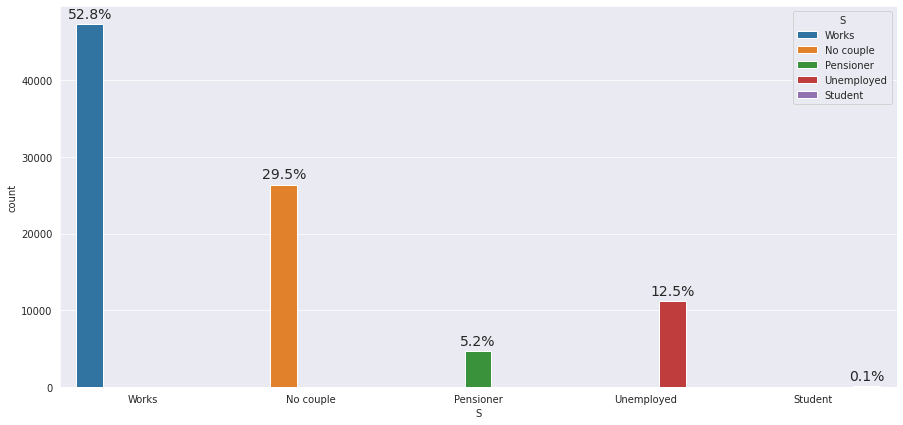

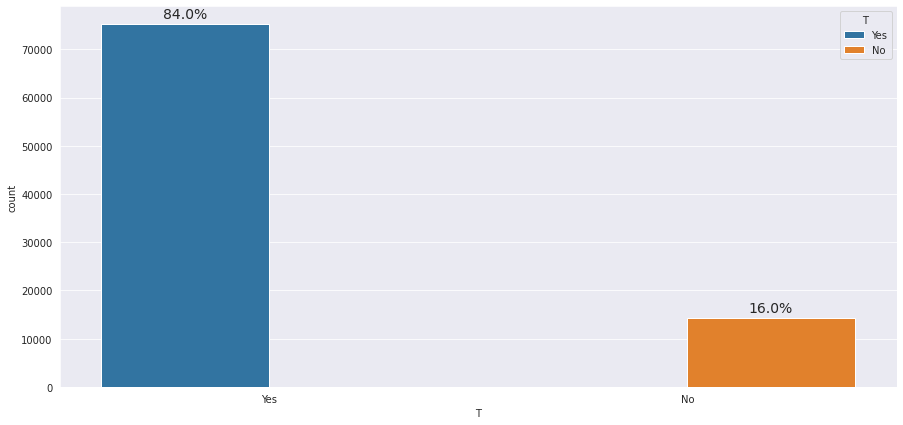

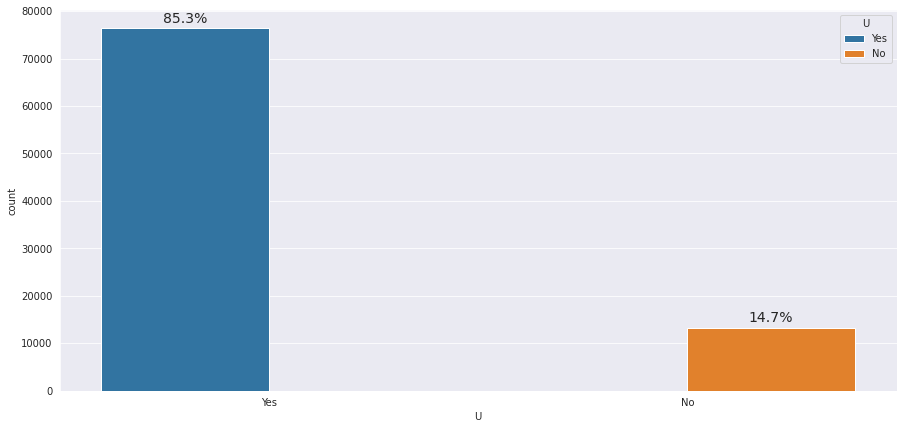

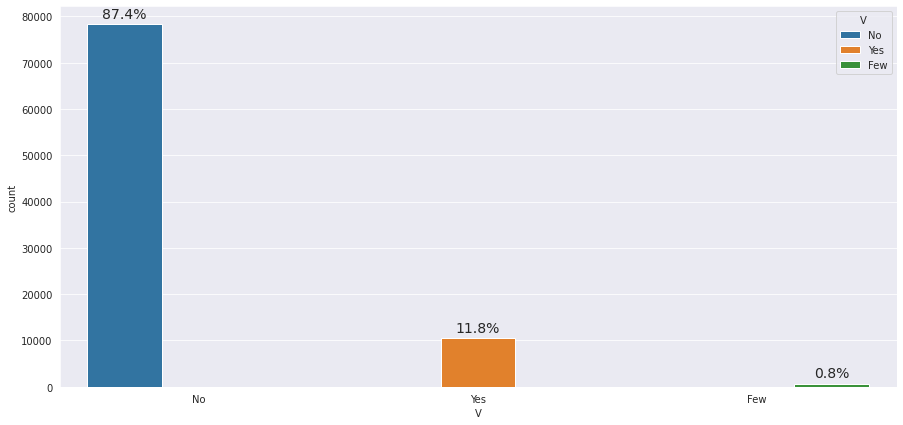

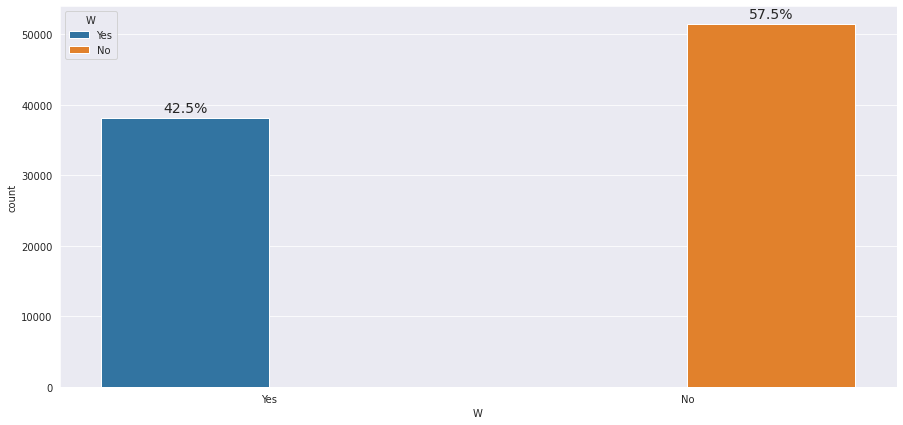

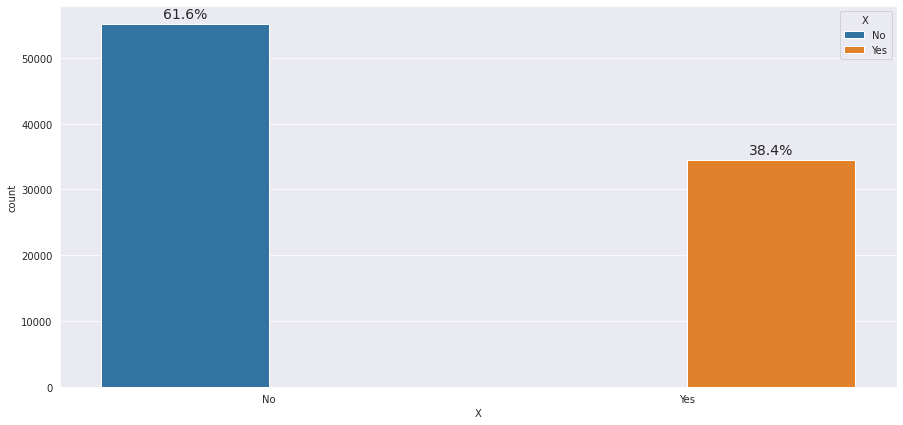

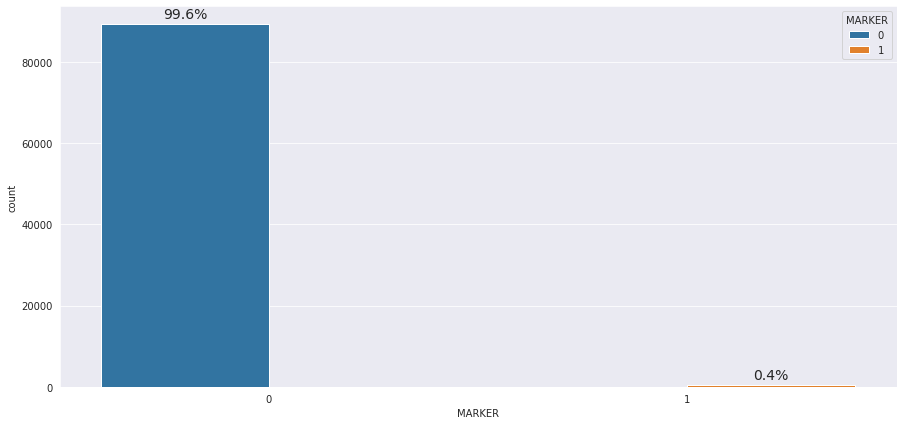

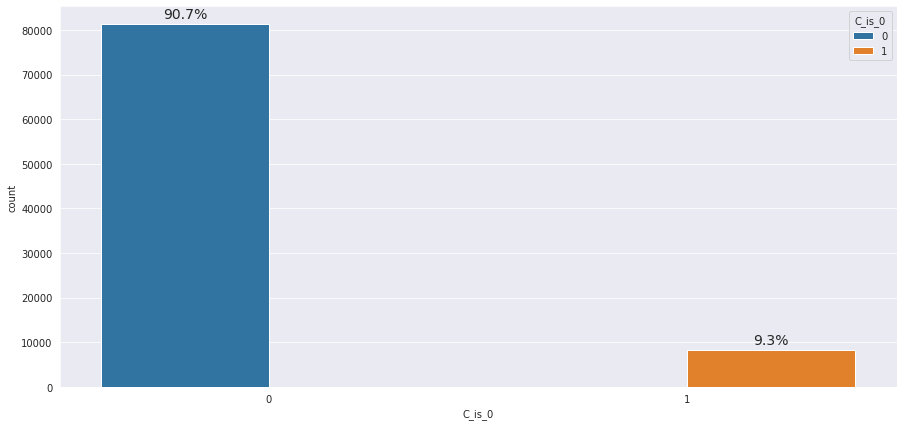

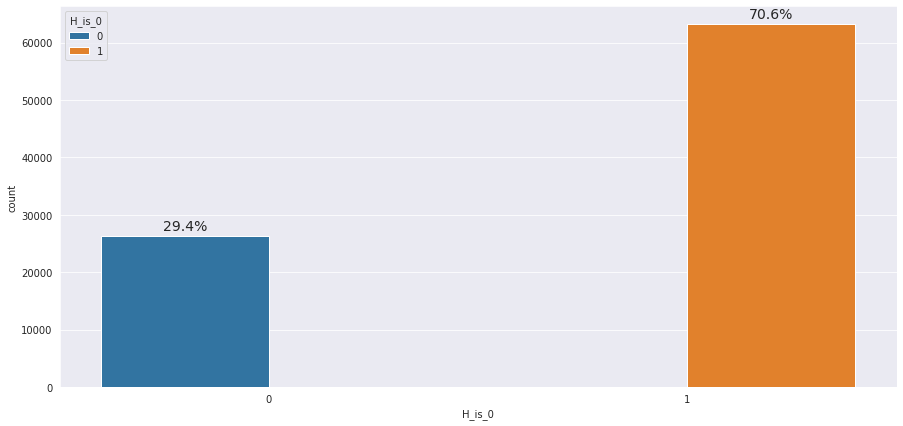

In [44]:
for col_name in cat_cols:
  plot_univariate_categorical(data, col_name, figsize=(15, 7))

- **I** - пол, в датасете немного больше женщин
- **K** - область, клиенты распределены по областям относительно равномерно
- **M** - что-то вроде рабочего статуса, судя по значениям признака (Head, Enterpreneur, etc.) NE employee может быть наёмным рабочим
- **S** вызывает вопросы, похоже на род деятельности, но что может значить значение "no couple" в данном контексте? К тому же, кол-во пенсионеров в признаке **S** отличается от кол-ва пенсионеров в признаке **M** и как согласуются "unemployed" и "student" со значениями признака **M**, в котором все кроме категории "pensioner" имеют какой-то рабочий статус?
- **N** - уровень образования
- **O** - семейное положение
- **P** - кол-во детей в семье? Значения колонок можно очистить и оставить только цифры
- **Q** - наличие квартиры?
- оставшиеся бинарные/тернарные признаки пока непонятно, как можно интерпретировать; думаю, что какой-то из них может быть ответом на вопрос "привлекались ли к уголовной/администартивной ответственности"

In [45]:
# rename column names
data.rename(columns={'J': 'age', 'I': 'sex', 'K': 'region', 'N': 'education', 'O': 'marital_status', 'P': 'n_children', 'Q': 'housing'}, inplace=True)
num_cols = data.select_dtypes(include='number').columns.tolist()
cat_cols = data.select_dtypes(include='object').columns.tolist()

# clean redundant info
data['n_children'] = data['n_children'].apply(lambda x: x.split()[0])

## Первоначальные гипотезы / вопросы для исследования

- имеет смысл определить, на какой вопрос отвечает целевая метка: заёмщик "хороший" (да - 1) или, наоборот, заёмщик "плохой" (да - 1)
- изучить распределение возраста в разрезе таргета (возраст "хороших" заёмщиков выше, чем возраст "плохих"?)
- изучить распределение пола в разрезе таргета (мужчины чаще берут кредит? женщинам выдают реже, потому что они могут находиться в декретном отпуске или только выйти из него?)
- изучить совместное влияние различных переменных (пол/возраст/семейное положение/кол-во детей/наличие собственности) в разрезе таргета
- изучить распределение областей в разрезе таргета
- изучить распределение рабочего статуса (**M**) в разрезе таргета (head'ам чаще выдают кредит?), изучить взаимодействие этой переменной с переменной **S**, попробовать разобраться, как они соотносятся
- изучить распределение семейного положения в разрезе таргета ("хорошие" заёмщики замужние/женатые, т.к. им проще вместе выплатить кредит?)
- изучить распределение кол-ва детей в разрезе таргета ("хорошие" имеют меньше (например, меньше финансовых обязательств, поэтому проще выплатить кредит) или больше (например, могут больше нуждаться в кредите) детей?)
- изучить распределение наличия собственности в разрезе таргета (у "хорошего" заёмщика своя квартира?)
- изучить распределение уровня образования в разрезе таргета (уровень образования "хороших" заёмщиков выше?)

## 2. Исследование взаимодействия между каждой переменной и таргетом

### 2.1 Числовые переменные

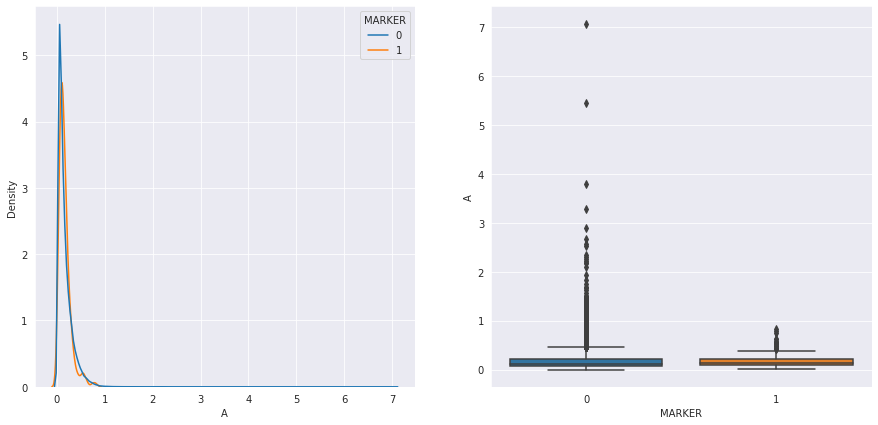

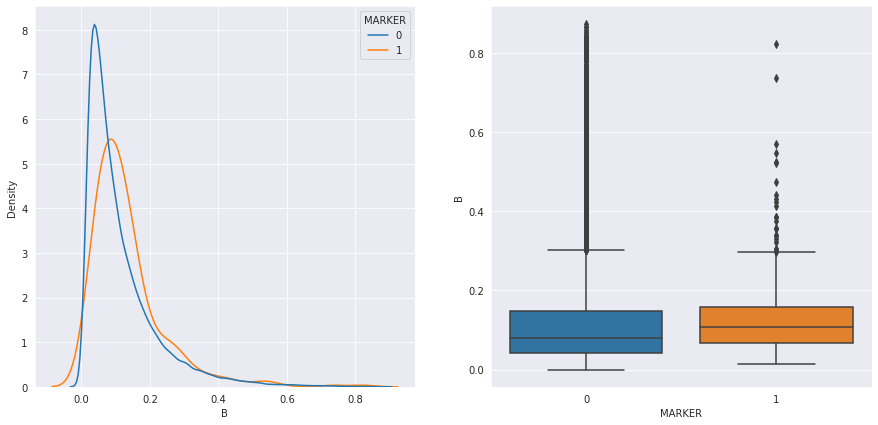

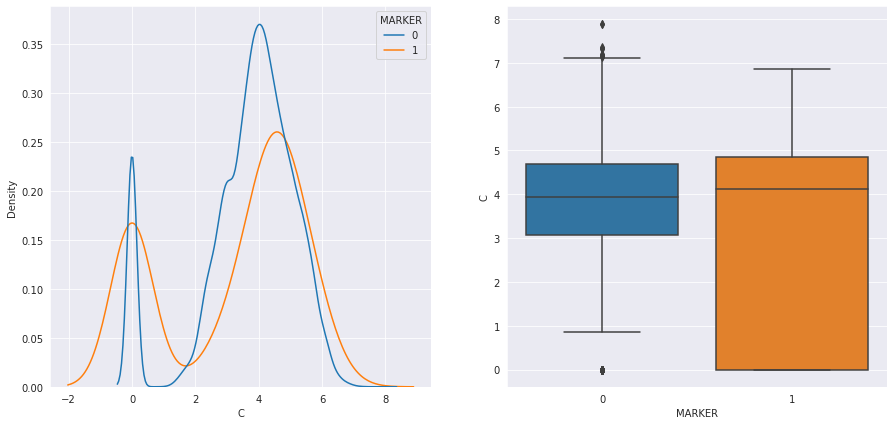

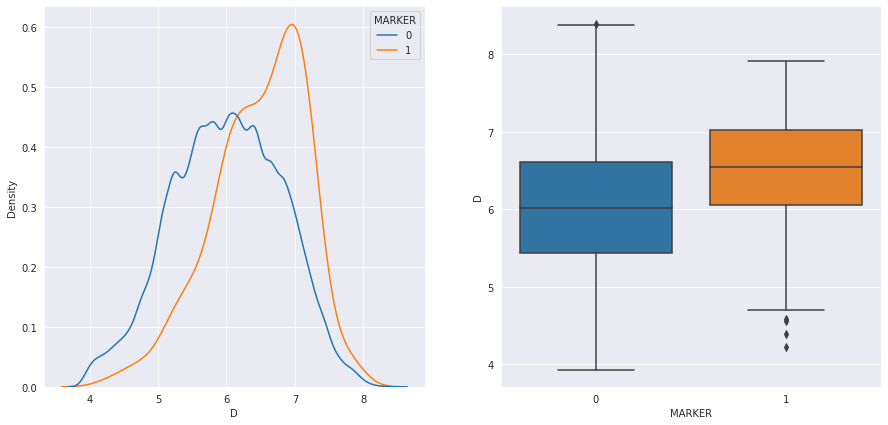

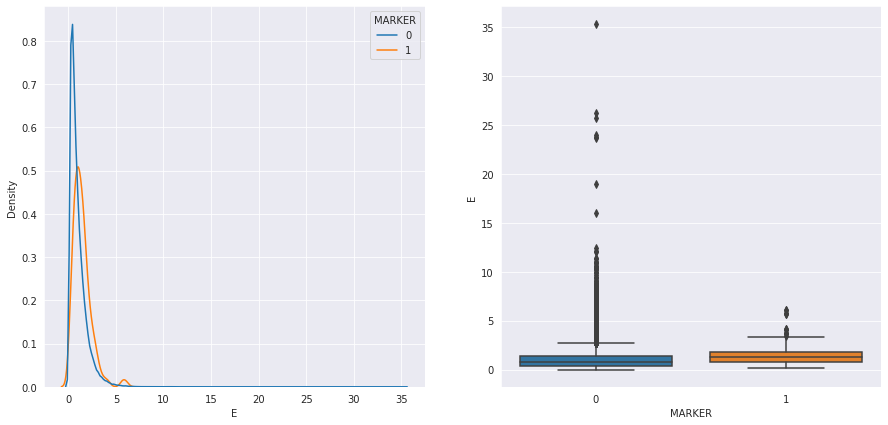

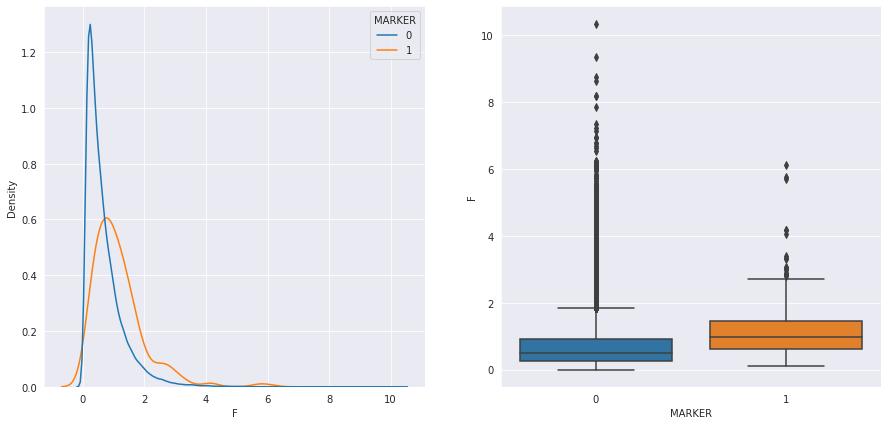

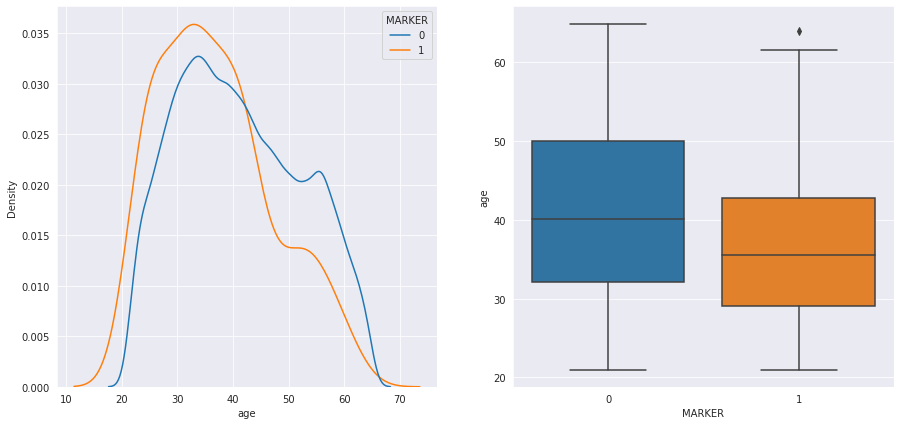

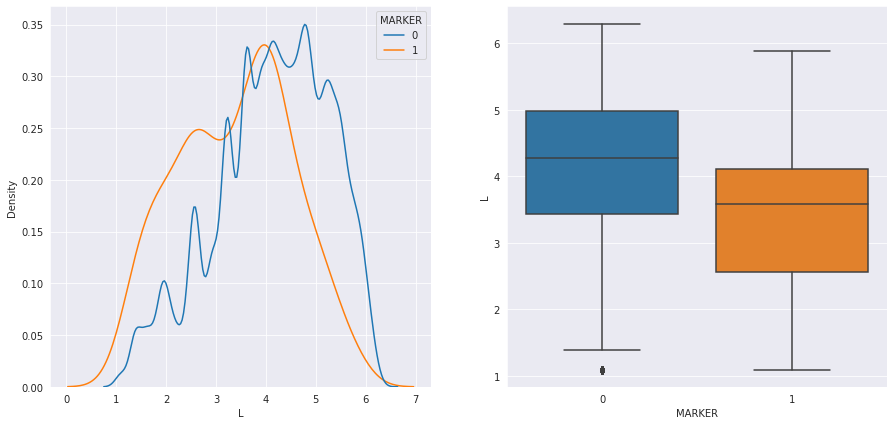

In [46]:
for col_name in num_cols:
    plot_bivariate_numeric(data, col_name, figsize=(15, 7))

Выводы:
- заметных различий по признакам **A**, **E** в разрезе таргета нет
- распределения признаков **B**, **D**, **F** в зависимости от флага таргета смещено в большую сторону при target = 1
- распределения признаков **age**, **L**  в зависимости от флага таргета смещено в меньшую сторону при target = 1
- если предположить, что гипотеза о возрасте верна (средний возраст "хорошего" заёмщика выше), тогда, исходя из графика возраста, можно сделать вывод, что целевая метка со значением 1 - индикатор "плохого" заёмщика; попробуем найти больше свидетельств этому при анализе категориальных признаков

### 2.1 Категориальные переменные

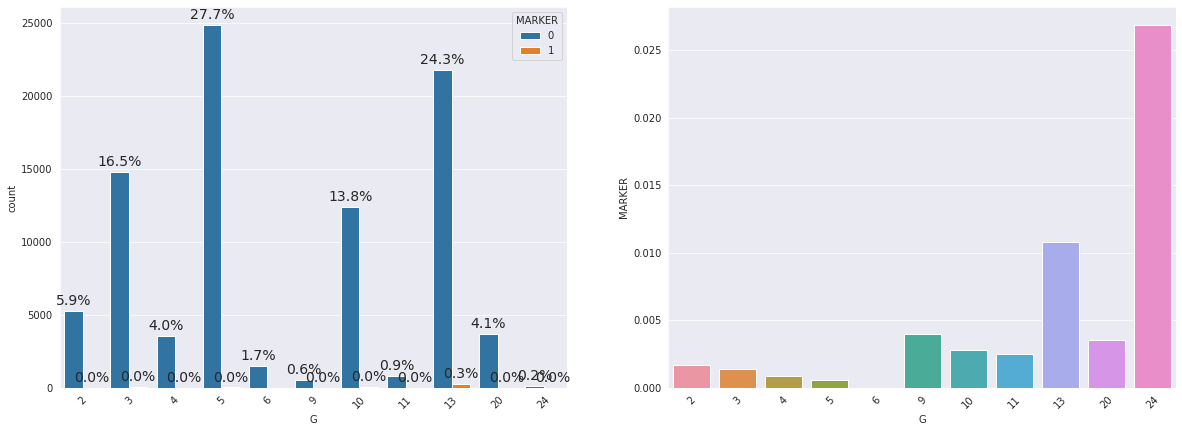

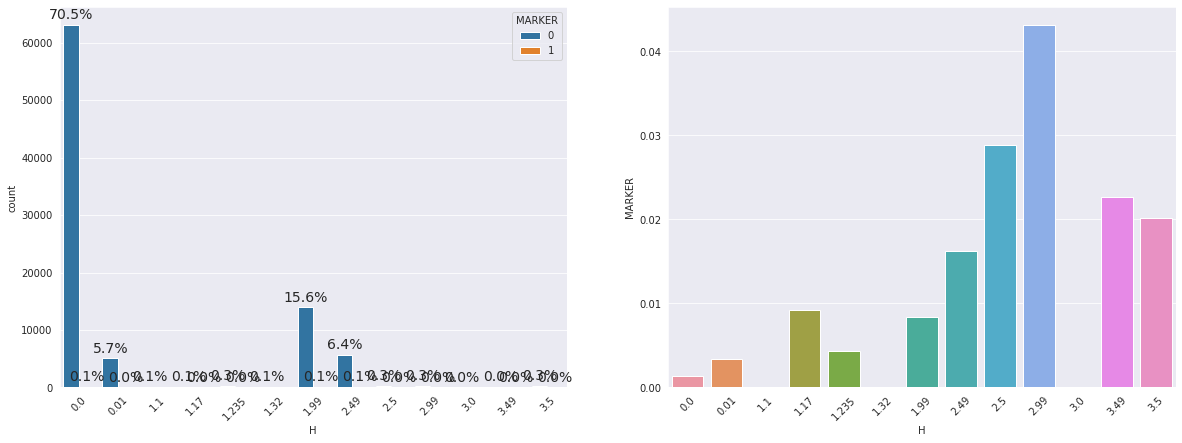

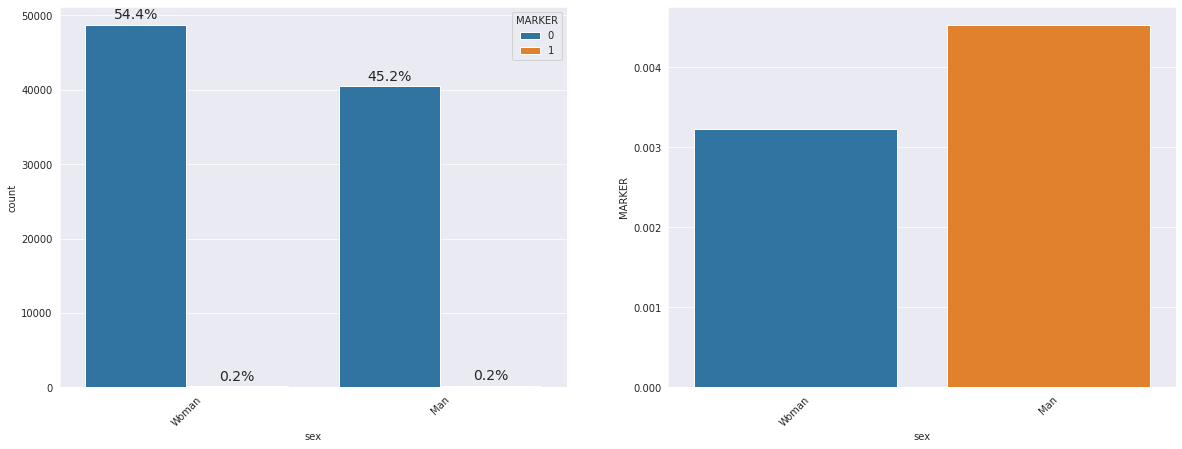

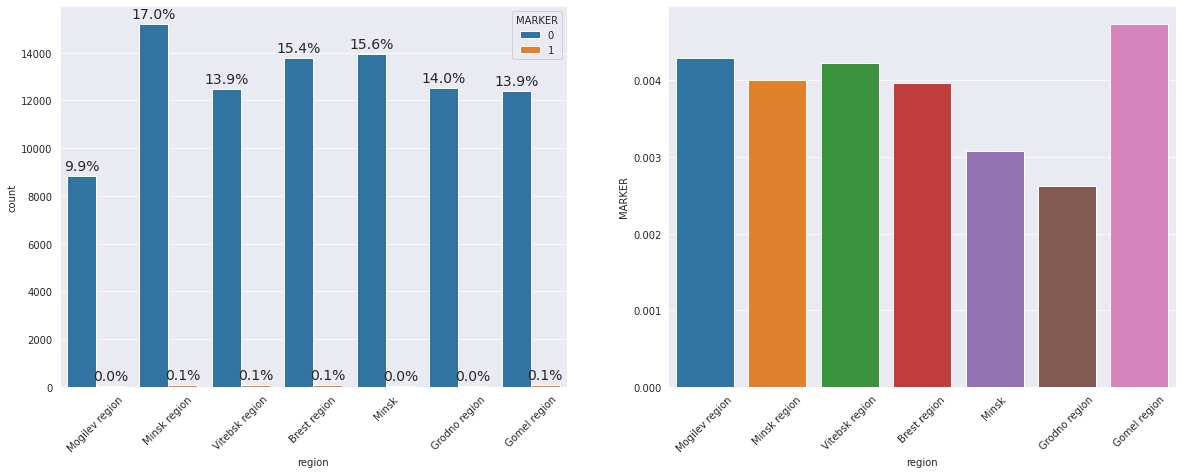

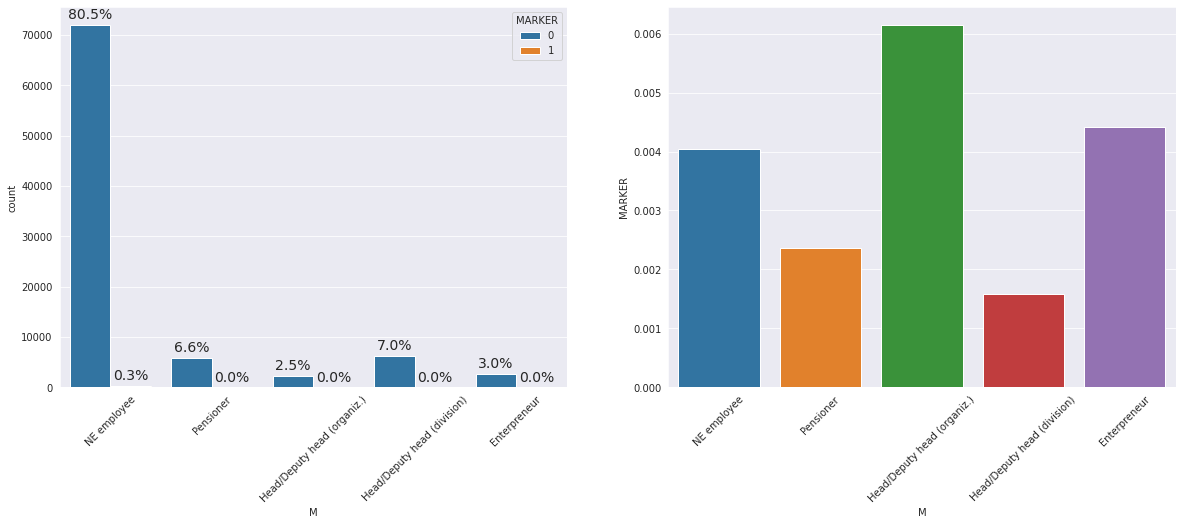

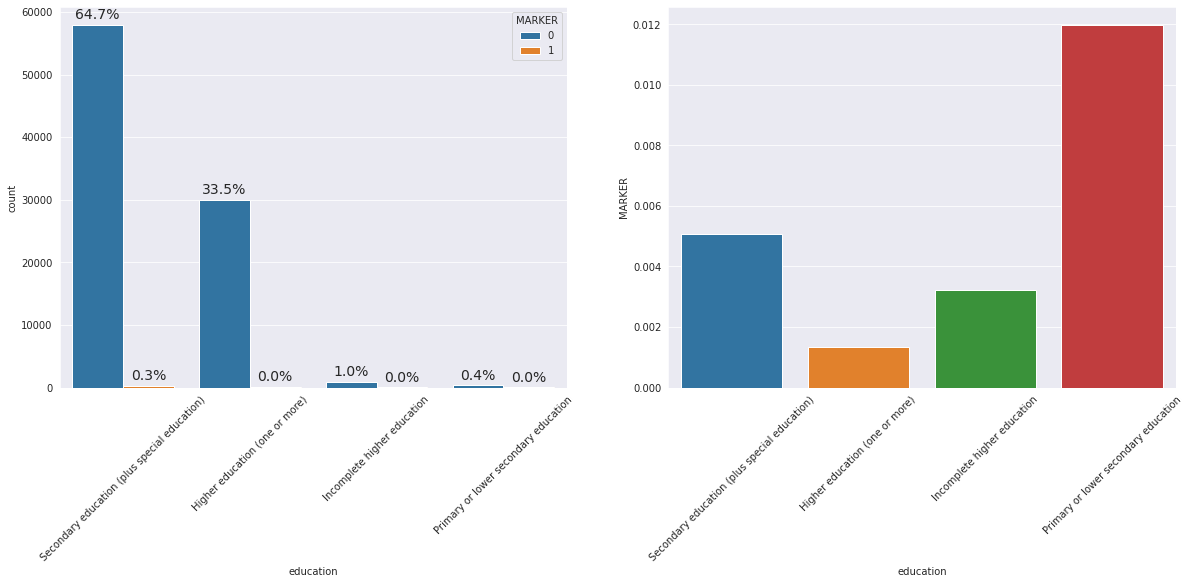

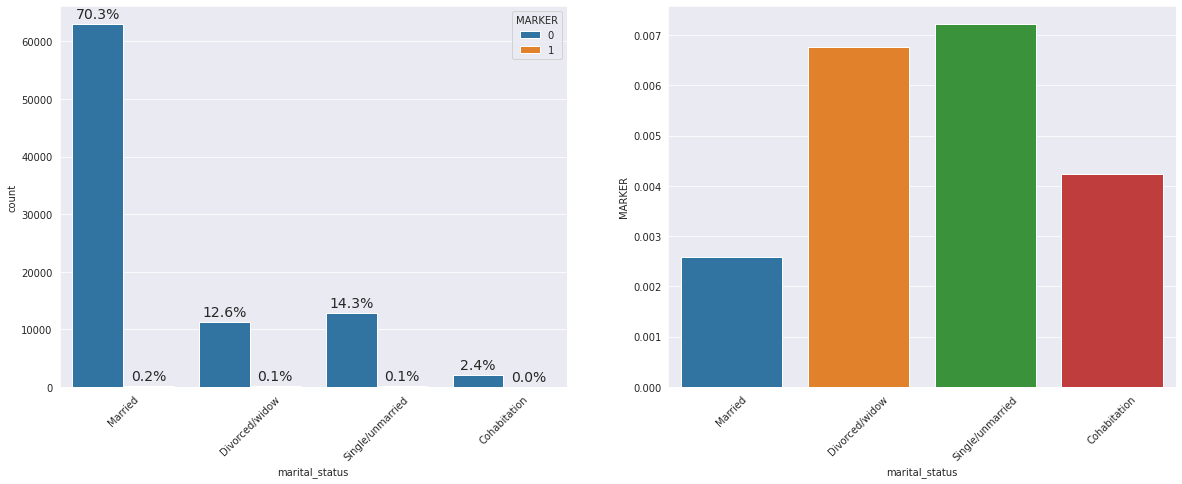

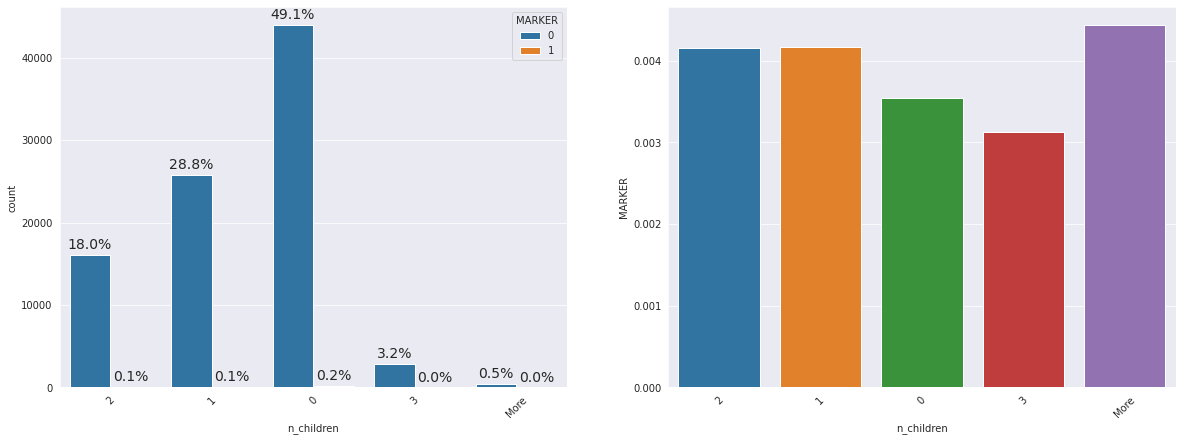

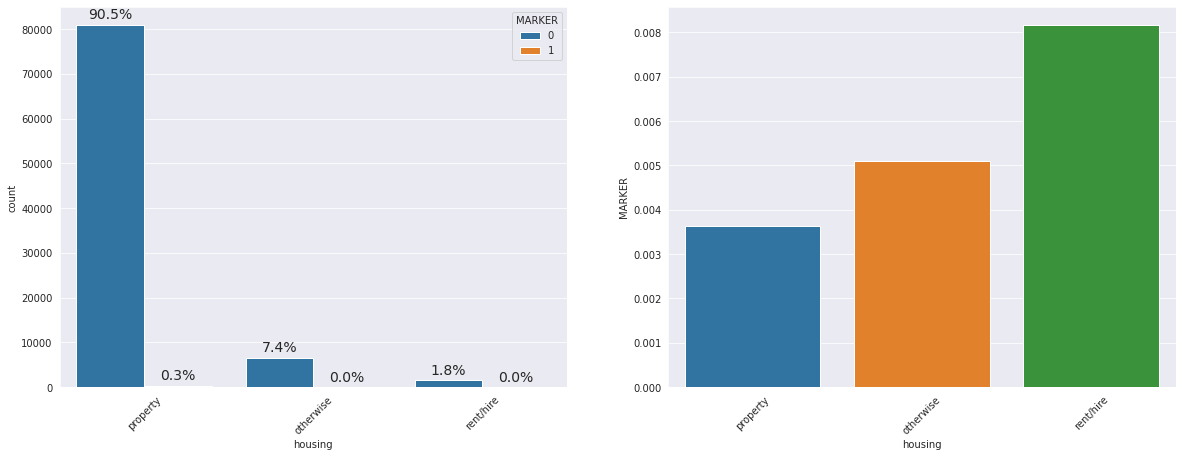

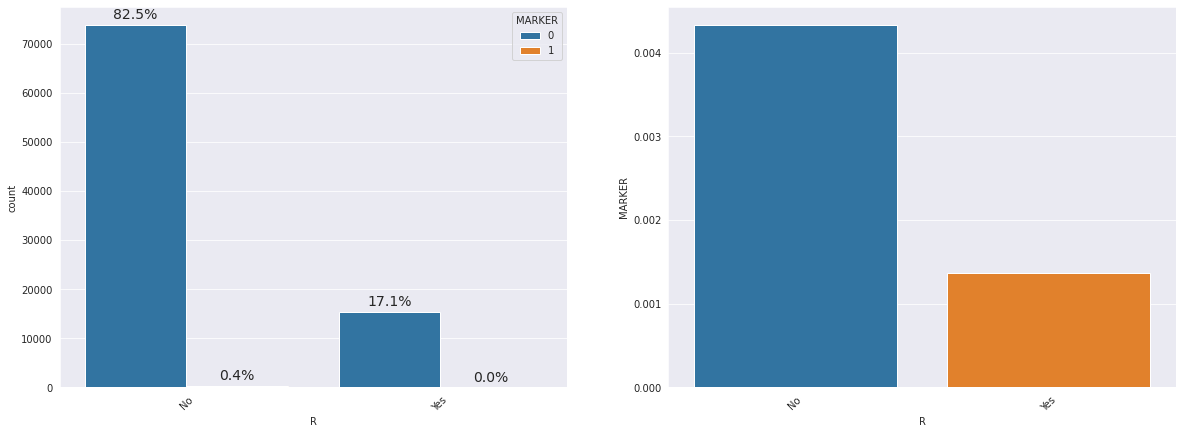

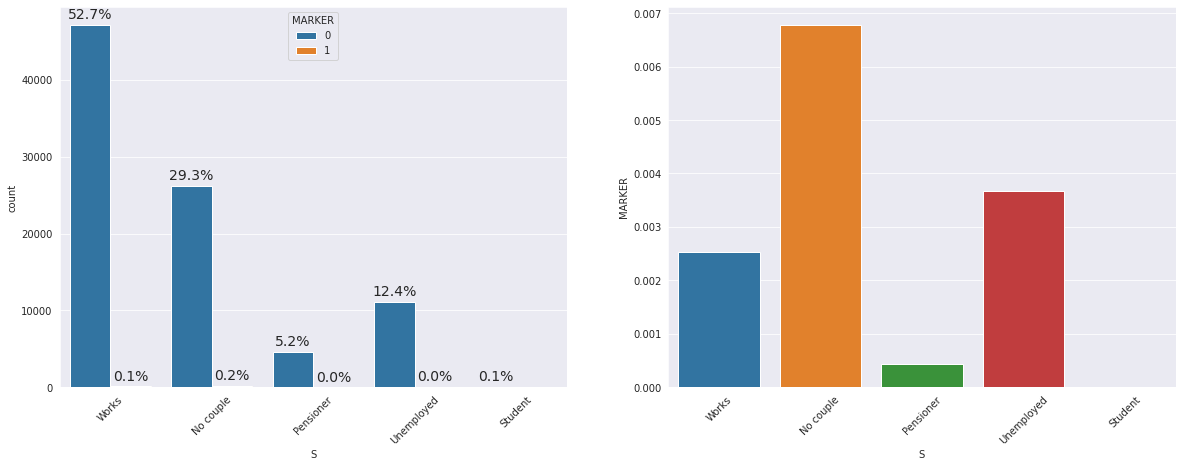

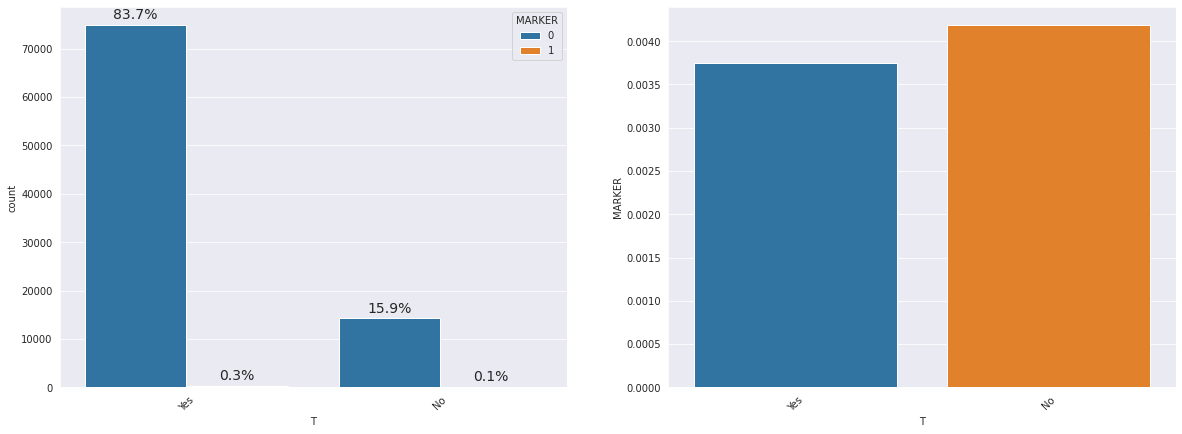

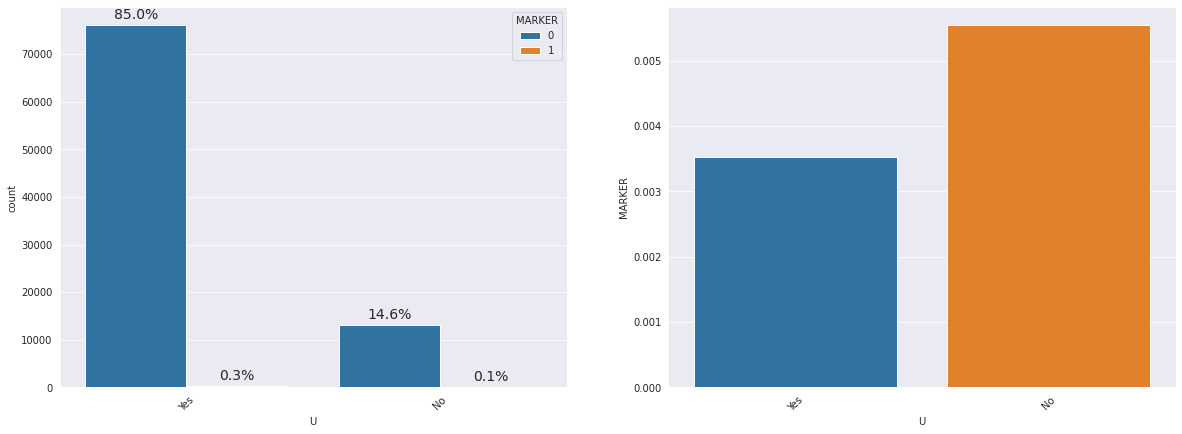

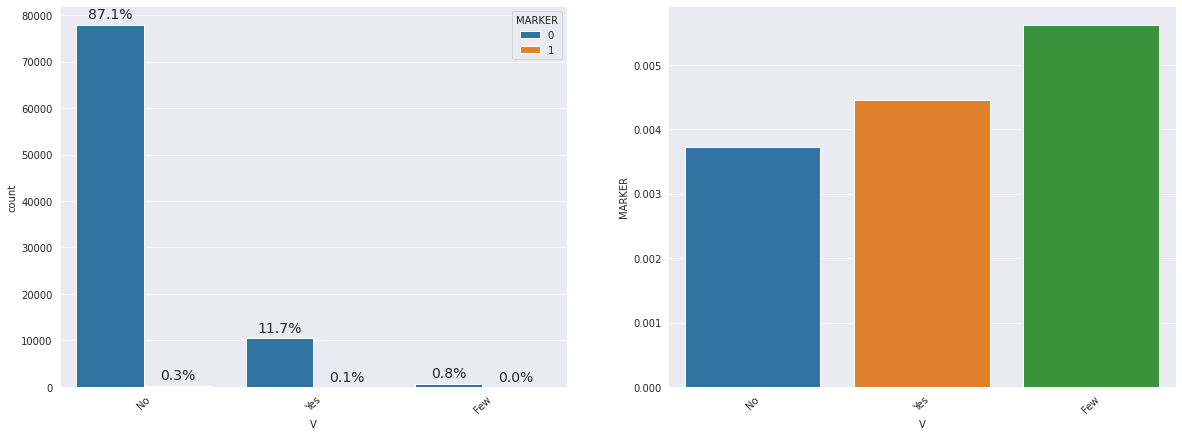

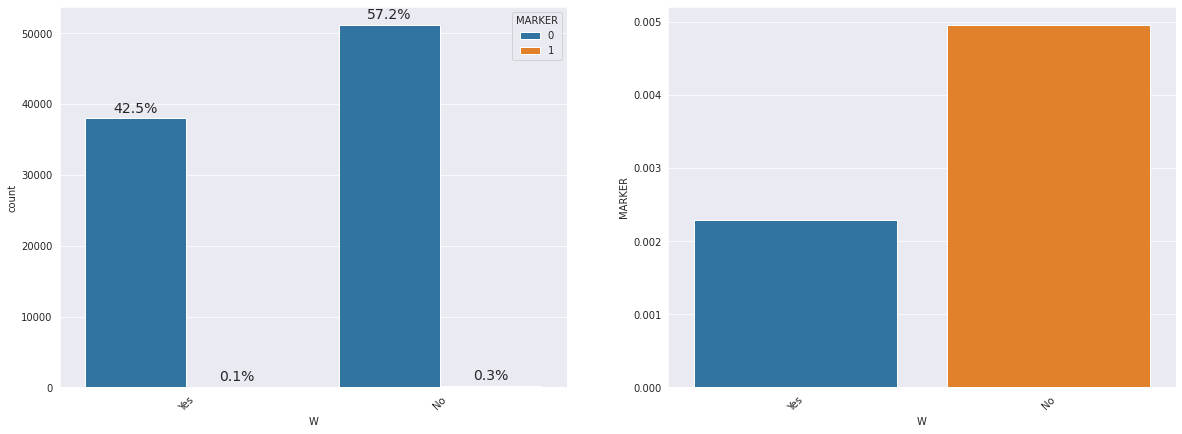

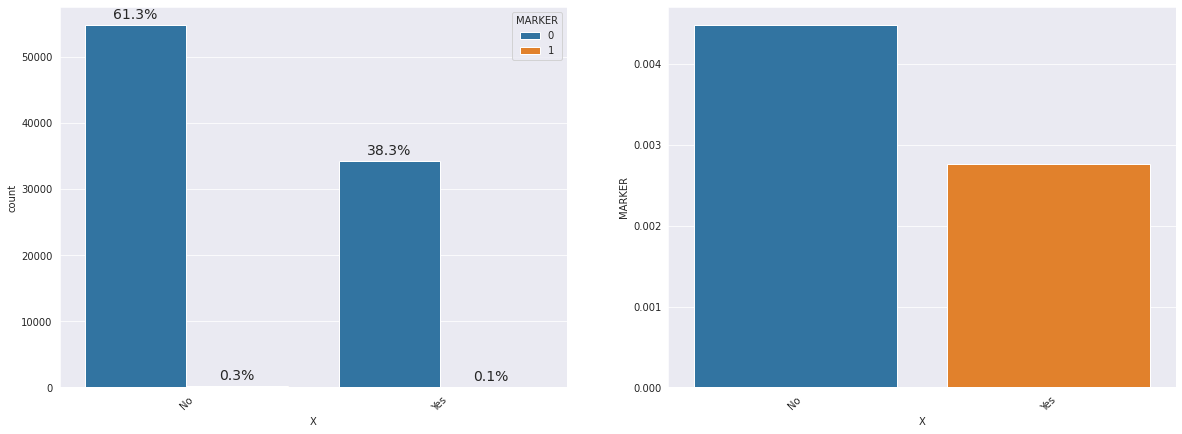

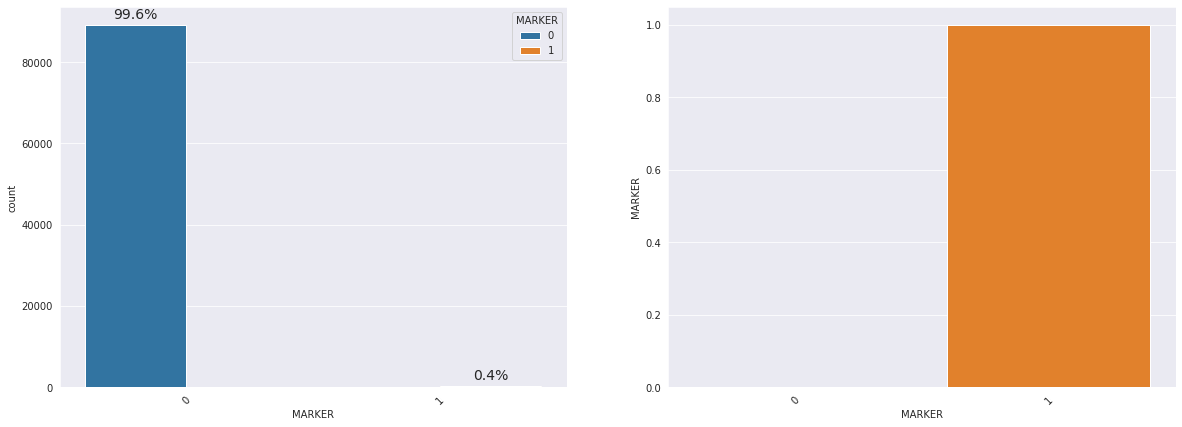

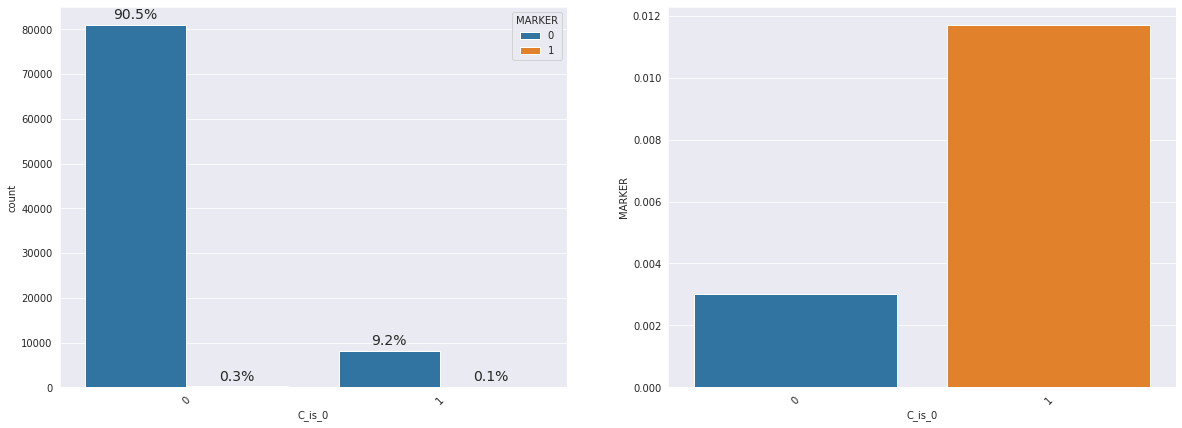

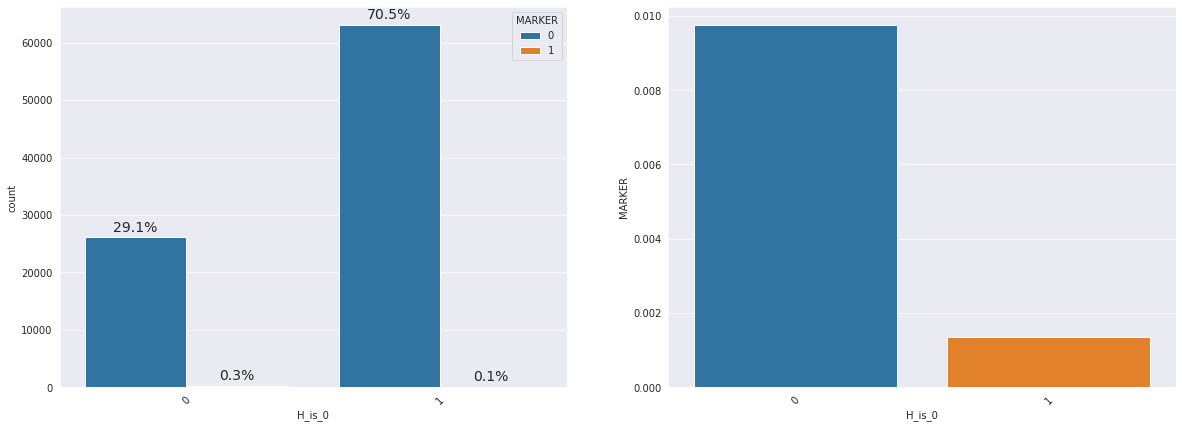

In [47]:
for col_name in cat_cols:
    plot_bivariate_categorical(data, col_name, figsize=(20, 7))

Наблюдения:
- **G**: самое большое кол-во представителей класса 1 среди G = 24, несмотря на то, что эта группа самая малочисленная; самая многочисленная группа (G = 5) практически самая "непопулярная" по представителям класса 1
- **H**: самое большое кол-во представителей класса 1 среди H = 2.99, следующими по кол-ву представителей класса 1 идут группы 2.5, 3.49, 3.5, хотя они самые немногочисленные; скорее всего, это полезный признак и не следует его заменять бинарным признаком H_is_0
- **sex**: среди мужчин больше представителей класса 1, хотя женщины в датасете преобладают по кол-ву; если класс 1 - "плохой заёмщик", то гипотеза о том, что женщинам реже выдают кредит, не подтвердилась
- **region**: по регионам кол-во представителей класса 1 распределено относительно равномерно, чуть меньше представителей класса 1 встречается в Минске и Гродненской области
- **education**: самое большое кол-во представителей класса 1 среди primary or lower secondary education; если класс 1 - "плохой заёмщик", то гипотеза о том, что у "хороших" заёмщиков выше уровень образования, подтвердилась
- **marital_status**: самое большое кол-во представителей класса 1 среди тех, кто divorced или unmarried; если класс 1 - "плохой заёмщик", то гипотеза о том, что женатый/замужний заёмщик более надежный, подтвердилась
- **n_children**: по кол-ву детей кол-во представителей класса 1 распределено относительно равномерно; немного больше представителей класса 1 среди тех, у кого более 3-х детей; если класс 1 - "плохой заёмщик", то можно объяснить это тем, что при таком большом кол-ве детей финансовых обязательств у заёмщика больше и высок риск, что он не выплатит кредит
- **housing**: самое большое кол-во представителей класса 1 среди тех, кто снимает квартиру; если класс 1 - "плохой заёмщик", то гипотеза о наличии собственности у "хорошего" заёмщика подтвердилась
- **M**: самое большое кол-во представителей класса 1 среди Head(organiz.), несмотря на то, что эта группа самая малочисленная; меньше всего представителей класса 1 среди Head(division) и Pensioner; если класс 1 - "плохой" заёмщик, то почему глава организации - "плохой" заёмщик, может это глава стартапа, которому нужны деньги на реализацию новой идеи, которая не всегда оказывается успешной? ))) если же класс 1 всё-таки "хороший" заёмщик, то почему кредит не выплачивает в таком случае Head(division)? Признак вводит в заблуждение, возможно, его можно просто удалить
- **S**: самое большое кол-во представителей класса 1 среди тех, кто не имеет пары или работы
- **R**, **U**, **W**, **X**: неизвестные бинарные признаки, но обладают каким-то разделяющим свойством (кол-во представителей класса 1 больше среди тех, у кого значение этого признака равно No); то же можно сказать про тернарный признак **V**
- **T**: неизвестный бинарный признак; кол-во представителей класса 1 распределено практически равномерно по этому признаку, наверное, можно его просто удалить, т.к. не несёт в себе полезной информации
- **С_is_0**: кол-во представителей класса 1 больше среди тех, у кого значение признака C = 0

Главные выводы:
- в целом, мы наблюдаем наличие сильных связей между числовыми/категориальными переменными и целевой меткой
- преобладание класса 1 среди безработных, незамужних/неженатых, более молодых, хуже образованных, без собственности свидетельствует о том, что класс 1 - "плохой" заёмщик

In [48]:
data.drop(columns=['H_is_0'], inplace=True)
cat_cols = data.select_dtypes(include='object').columns.tolist()

## 3. Исследование взаимодействий между признаками

sex/age/target:

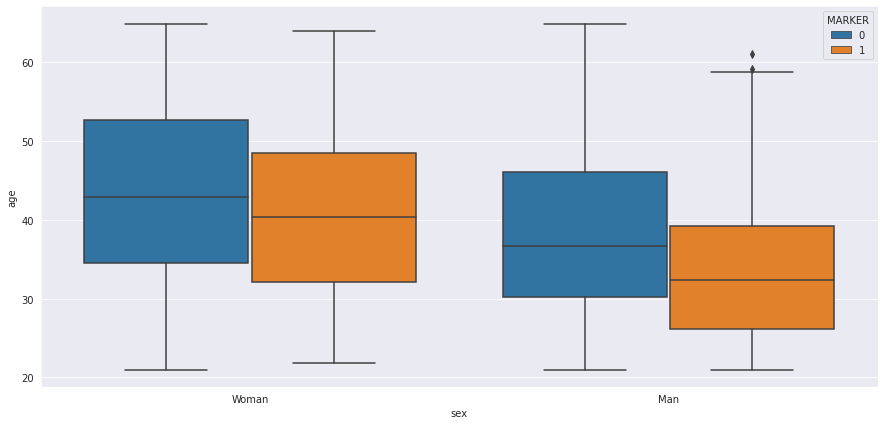

In [49]:
plot_num_cat_boxplot(data, num_col_name='age', cat_col_name='sex', figsize=(15,7))

- средний возраст "плохих" заёмщиков ниже как среди мужчин, так и среди женщин, но в целом средний возраст женщин выше, чем средний возраст мужчин; "плохой" заёмщик - скорее молодой мужчина, что согласуется с выводами, которые мы сделали ранее

S/M/target:

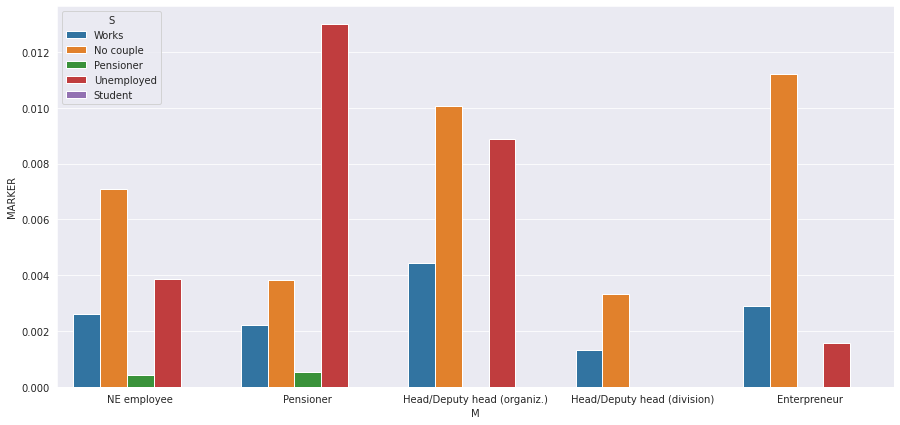

In [50]:
plot_multiple_barplot(data, x='M', hue='S', figsize=(15,7))

- всё ещё возникают трудности в интепретации этих двух признаков
- в целом, никаких новых выводов: по всем категориям более ненадежным заёмщиком является тот, у кого нет пары или нет работы

S/sex/target:

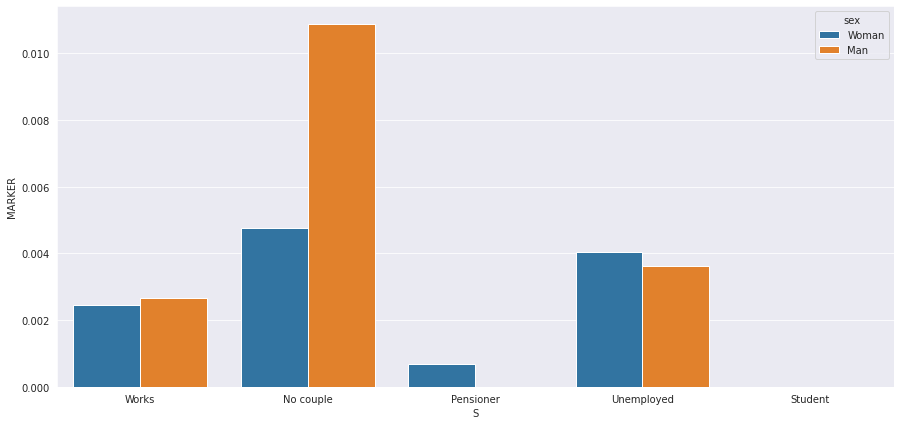

In [51]:
plot_multiple_barplot(data, x='S', hue='sex', figsize=(15,7))

По этому графику можно сделать несколько забавных выводов:
- безработные мужчины возвращают кредиты немного чаще, чем безработные женщины
- одинокие мужчины какие-то сильно более ненадежные, чем одиникое женщины

Можно помочь модели увидеть подобные зависимости и создать новые признаки по типу x1*x2

Проверим числовые признаки на наличие сильной корреляции между собой, т.к. это может быть проблемой при работе с линейными моделями:

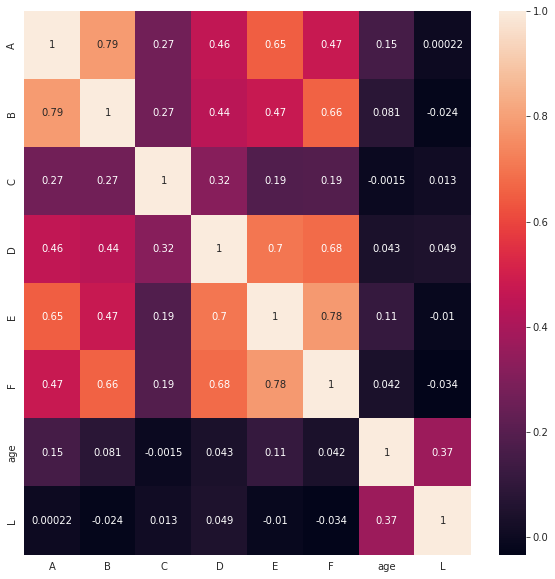

In [52]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

- признак **A** сильно скореллирован с признаком **B**
- признак **E** сильно скоррелирован с признаком **F**

Мы можем удалить признаки **A** и **E**, т.к. в предыдущей части анализа мы установили, что заметных различий по этим признакам в разрезе таргета нет; либо использовать логистическую регрессию с регуляризацией и посмотреть, какие признаки она отберёт

# Резюме

Был произведен анализ и оценка возможности использования признаков предоставленного набора данных, в результате чего сделаны следующие выводы:
- решается задача предсказания дефолта клиента
- MARKER (целевая метка) - бинарный признак и имеет огромный дисбаланс (99,6% объектов класса 0), мы должны учитывать это при выборе метрик и их оценке
- пропущенных значений в исходном датасете не обнаружено (значение признака C = 0 может быть индикатором пропущенного значения)
- дублирующихся строк в исходном датасете не обнаружено
- исходный датасет содержит 26 столбцов. Признак ID нецелесообразно использовать для построения модели, т.к. он является уникальным для всех объектов
- среди оставшихся признаков 10 числовых и 15 категориальных (один из которых - целевая метка), двое из числовых признаков было решено рассматривать как категориальные
- числовые признаки были изучены на наличие сильной корреляции
- большинство признаков показали наличие связи с целевой меткой